# Al Nuclear Excited States

An Ipython notebook for fitting experimentally extracted form factors from the electroexcitation of Al nuclear excited states.

In [1]:
import numpy as np

In [2]:
#This following is so that this will work with Latex, see
#http://bkanuka.com/articles/native-latex-plots/
import matplotlib as mpl
mpl.use('pgf')

In [48]:
def figsize(scale):                                 # I think scale is the size you want it on the page
    fig_width_pt = 433.62001                        # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.0                        # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_lualatex = {                      # Setup matplotlib to use latex for output
    "pgf.texsystem": "lualatex",           # Change this if using xetex or luatex
    "text.usetex": True,                   # Use LaTeX to write all text
    #Fonts
    "font.family": "serif",                # Get from the pdf font function on the doc
    "font.serif": "Computer Modern Roman",      
    "font.sans-serif": "Computer Modern Sans serif",
    "font.monospace": [], # Blank entries should cause plots to inherit fonts from the document
    #Text size
    "font.size": 11,# Document default is 11pt font.
    #"text.fontsize": 11,
    "axes.labelsize": 11,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    ##Axis
    #"axes.labelpad": 2,     # space between label and axis 
    "figure.figsize": figsize(1.0),     # default fig size of 1.0 textwidth
    #Packages
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        r"\usepackage{amsmath}",  #need to add math or the ^ won't work
        r"\usepackage{amssymb}"]
    }

mpl.rcParams.update(pgf_with_lualatex)

In [49]:
import matplotlib.pyplot as pp
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit

In [27]:
%matplotlib inline
pp.style.use('seaborn-ticks')
sns.set_palette("muted")
#plot_size = 6*np.array([1.0,(2.0/(1.0+np.sqrt(5.0)))]) #Use Golden ratio as aspect ratio for plots

In [54]:
# Plot range ranges
x_low = 0.3 # [1/fm]
x_high = 2.5 # [1/fm]
y_low = 1e-6
y_high = 1e-2

fit_x_range = np.linspace(x_low,x_high,1e3)

qweak_acceptance = (0.676, 1.188)# Qweak Q acceptance [1/fm]
#qweak_acceptance = (0.0178, 0.0550)# Qweak Q^2 acceptance [GeV^2]

#fit_range = (0.5, 1.4) # [1/fm]
fit_range = (0.3, 1.8) # [1/fm]
#fit_range = qweak_acceptance

energy_lvl = ('0.844', 
              '1.014',
              '2.211',
              '2.735',
              '2.990',
              '3.680',
              '3.957',
              '4.055',
              '4.410',
              '4.510',
              '4.580',
              '4.812',
              '5.156',
              '5.248',
              '5.430',
              '5.500',
              '5.551',
              '5.668',
              '5.827',
              '5.960',
              '6.160',
              '6.477',
              '6.520',
              '6.605',
              '6.6515',
              '6.710',
              '6.948',
              '7.228',
              '7.290',
              '7.410',
              '7.477',
              '7.580',
              '7.660',
              '7.800',
              '8.400',
              '8.520',
              '8.820')

In [116]:
# Define functions
def gaussian(x, const, mu, sigma):
    'Gaussian Fit Function'
    numerator = -1.0*np.square(x-mu)
    denominator = 2.0*np.square(sigma)
    return const * np.exp(numerator/denominator)

def gaussian_err(x, pcov, const, mu, sigma):
    'Error Function for Gaussian Fit'
    
    # Calculate partials
    df_dc = gaussian(x, 1.0, mu, sigma)
    df_dmu = ((const*(x-mu))/(sigma*sigma))*gaussian(x, 1.0, mu, sigma)
    df_dsig = ((const*np.square(x-mu))/(sigma*sigma*sigma))*gaussian(x, 1.0, mu, sigma)
    
    const_term = pcov[0,0]*df_dc*df_dc
    mu_term = pcov[1,1]*df_dmu*df_dmu
    sigma_term = pcov[2,2]*df_dsig*df_dsig
    c_mu_term = 2.0*pcov[0,1]*df_dc*df_dmu
    c_sigma_term = 2.0*pcov[0,2]*df_dc*df_dsig
    mu_sigma_term = 2.0*pcov[1,2]*df_dmu*df_dsig

    return np.sqrt(const_term + mu_term + sigma_term + c_mu_term + c_sigma_term + mu_sigma_term)

def print_fit_info(popt, pcov, chi2, dof, ravg, ravg_err):
    'Print Fit Parameters'
    string = 'Constant: {0:.3e} +- {1:.3e} \n\
    Mean: {2:.7f} +- {3:.7f} \n\
    Sigma: {4:.7f} +- {5:.7f} \n\
    Chi**2: {6:.3f} \n\
    DOF: {7:d} \n\
    RChi**2: {8:.3f} \n\
    ResidualAvg: {9:.3f} +- {10:.3f}'.format(popt[0], 
                                             np.sqrt(pcov[0,0]),
                                             popt[1], 
                                             np.sqrt(pcov[1,1]), 
                                             popt[2], 
                                             np.sqrt(pcov[2,2]), 
                                             chi2, 
                                             dof, 
                                             chi2/dof, 
                                             ravg, 
                                             ravg_err)
    return print(string)

def pdiff(data,fit):
    return 100.0*(data - fit)/data

def pdiff_err(data, data_err, fit, fit_err):
    df_ddata = (100.0*fit)/(data*data)
    df_dfit = -100.0/data
    
    data_term = data_err*data_err*df_ddata*df_ddata
    fit_term = fit_err*fit_err*df_dfit*df_dfit
    return np.sqrt(data_term + fit_term)

def chi2(x,y,y_err,popt):
    return np.sum(np.square((y-gaussian(x, *popt))/y_err))

def Q_eff_angle_cut(data):
    return data.Q_eff[(data.theta < 160.0)]

def FF_angle_cut(data):
    return data.f_total_sq[(data.theta < 160.0)]

def Err_angle_cut(data):
    return data.xsection_err[(data.theta < 160.0)]

def Q_eff_fit_cut(data, low, high):
    return data.Q_eff[(data.theta < 160.0) & (data.Q_eff > low) & (data.Q_eff < high)]

def FF_fit_cut(data, low, high):
    return data.f_total_sq[(data.theta < 160.0) & (data.Q_eff > low) & (data.Q_eff < high)]

def Err_fit_cut(data, low, high):
    return data.xsection_err[(data.theta < 160.0) & (data.Q_eff > low) & (data.Q_eff < high)]

def fit_plot(Q_eff, ff, err, popt, pcov, lvl):
    fig = pp.figure(figsize=figsize(1.0))
    pp.errorbar(Q_eff, 
                ff, 
                yerr=err, 
                ls='None', 
                marker='o', 
                capsize=5,
                capthick=1,
                color=sns.xkcd_rgb['denim blue'],
                label='MIT Bates')
    pp.plot(fit_x_range, 
            gaussian(fit_x_range, *popt), 
            ls='-', 
            color=sns.xkcd_rgb['pale red'], 
            label='Gaussian Fit')
    pp.fill_between(fit_x_range, 
                    gaussian(fit_x_range, *popt)-gaussian_err(fit_x_range, pcov, *popt), 
                    gaussian(fit_x_range, *popt)+gaussian_err(fit_x_range, pcov, *popt), 
                    color=sns.xkcd_rgb['pale red'], 
                    alpha=0.2)
    pp.xlim(x_low,x_high)
    pp.ylim(y_low,y_high)
    pp.fill_between(qweak_acceptance, 
                    y_low, 
                    y_high, 
                    color=sns.xkcd_rgb['steel grey'], 
                    alpha=0.2, 
                    label='Qweak \nAcceptance')
    pp.yscale('log')
    pp.title('{0} MeV Nuclear Excited State'.format(lvl))
    pp.xlabel('Q$_{eff}$ [fm$^{-1}$]')
    pp.ylabel('$|$FF$|^{2}$')
    pp.legend(bbox_to_anchor=(1.30, 1.0))
    pp.tick_params(top=False)
    pp.savefig('plots/al_{0}MeV_fit_plot.pdf'.format(lvl), bbox_inches='tight')
    pp.savefig('plots/al_{0}MeV_fit_plot.png'.format(lvl), bbox_inches='tight')
    pp.savefig('plots/al_{0}MeV_fit_plot.pgf'.format(lvl), bbox_inches='tight')
    #pp.show()
    return fig

def fit_plot_plus(Q_eff, ff, err, S_Q_eff, S_ff, S_err, popt, pcov, lvl):
    fig = pp.figure(figsize=figsize(1.0))
    pp.errorbar(Q_eff, 
                ff, 
                yerr=err, 
                ls='None', 
                marker='o', 
                capsize=5,
                capthick=1,
                color=sns.xkcd_rgb['denim blue'],
                label='MIT Bates')
    pp.errorbar(S_Q_eff, 
                S_ff, 
                yerr=S_err, 
                ls='None', 
                marker='^', 
                capsize=5,
                capthick=1,
                color=sns.xkcd_rgb['medium green'],
                label='Glasgow')
    pp.plot(fit_x_range, 
            gaussian(fit_x_range, *popt), 
            ls='-', 
            color=sns.xkcd_rgb['pale red'], 
            label='Gaussian Fit')
    pp.fill_between(fit_x_range, 
                    gaussian(fit_x_range, *popt)-gaussian_err(fit_x_range, pcov, *popt), 
                    gaussian(fit_x_range, *popt)+gaussian_err(fit_x_range, pcov, *popt), 
                    color=sns.xkcd_rgb['pale red'], 
                    alpha=0.2)
    pp.xlim(x_low,x_high)
    pp.ylim(y_low,y_high)
    pp.fill_between(qweak_acceptance, 
                    y_low, 
                    y_high, 
                    color=sns.xkcd_rgb['steel grey'], 
                    alpha=0.2, 
                    label='Qweak \nAcceptance')
    pp.yscale('log')
    pp.title('{0} MeV Nuclear Excited State'.format(lvl))
    pp.xlabel('Q$_{eff}$ [$fm^{-1}$]')
    pp.ylabel('$|$FF$|^{2}$')
    pp.legend(bbox_to_anchor=(1.30, 1.0))
    pp.tick_params(top=False)
    pp.savefig('plots/al_{0}MeV_fit_plot.pdf'.format(lvl), bbox_inches='tight')
    pp.savefig('plots/al_{0}MeV_fit_plot.png'.format(lvl), bbox_inches='tight')
    pp.savefig('plots/al_{0}MeV_fit_plot.pgf'.format(lvl), bbox_inches='tight')
    #pp.show()
    return fig

def fit_error_plot(popt, pcov, lvl):
    fig = pp.figure(figsize=figsize(1.0))
    pp.plot(fit_x_range, 
            100.0*(gaussian_err(fit_x_range, pcov, *popt)/gaussian(fit_x_range, *popt)), 
            ls='-', 
            color=sns.xkcd_rgb['denim blue'], 
            label='Gaussian Fit \nUncertainty')
    vert_low, vert_high = pp.ylim()
    pp.fill_between(qweak_acceptance, 
                    vert_low, 
                    vert_high, 
                    color=sns.xkcd_rgb['steel grey'], 
                    alpha=0.2, 
                    label='Qweak \nAcceptance')
    pp.xlim(x_low,x_high)
    pp.title('{0} MeV Nuclear Excited State'.format(lvl))
    pp.xlabel('Q$_{eff}$ [fm$^{-1}$]')
    pp.ylabel('$\sigma_{|FF|^{2}}$/$|$FF$|^{2}$ [\%]')
    pp.legend(bbox_to_anchor=(1.30, 1.0))
    pp.tick_params(top=False)
    pp.savefig('plots/al_{0}MeV_fit_uncertainty_plot.pdf'.format(lvl), bbox_inches='tight')
    pp.savefig('plots/al_{0}MeV_fit_uncertainty_plot.png'.format(lvl), bbox_inches='tight')
    pp.savefig('plots/al_{0}MeV_fit_uncertainty_plot.pgf'.format(lvl), bbox_inches='tight')
    return fig

def residual_plot(Q_eff_fit, pdiff, pdiff_err, ravg, ravg_err, lvl):
    fig = pp.figure(figsize=figsize(1.0))
    pp.errorbar(Q_eff_fit, 
                pdiff,
                yerr= pdiff_err,
                ls='None', 
                marker='d',
                capsize=5,
                capthick=1,
                color=sns.xkcd_rgb['medium green'],
                label='Residual')
    pp.plot((fit_range[0],fit_range[1]),(ravg,ravg), 
            ls='-', 
            color=sns.xkcd_rgb['pale red'], label='Avg')
    pp.fill_between((fit_range[0],fit_range[1]), 
                    ravg-ravg_err, 
                    ravg+ravg_err, 
                    color=sns.xkcd_rgb['pale red'], 
                    alpha=0.2)
    pp.xlim(fit_range[0],fit_range[1])
    vert_low, vert_high = pp.ylim()
    pp.fill_between(qweak_acceptance, 
                    vert_low, 
                    vert_high, 
                    color=sns.xkcd_rgb['steel grey'], 
                    alpha=0.2, 
                    label='Qweak \nAcceptance')
    pp.title('{0} MeV Nuclear Excited State'.format(lvl))
    pp.xlabel('Q$_{eff}$ [fm$^{-1}$]')
    pp.ylabel('$\\frac{Data - Fit}{Data}$ [\%]')
    pp.legend(bbox_to_anchor=(1.30, 1.0))
    pp.tick_params(top=False)
    pp.savefig('plots/al_{0}MeV_residual_plot.pdf'.format(lvl), bbox_inches='tight')
    pp.savefig('plots/al_{0}MeV_residual_plot.png'.format(lvl), bbox_inches='tight')
    pp.savefig('plots/al_{0}MeV_residual_plot.pgf'.format(lvl), bbox_inches='tight')
    #pp.show()
    return fig
def plot_combo(Q_eff, Q_eff_fit, ff, err, popt, pcov, chi2, pdiff, pdiff_err, ravg, ravg_err, lvl):
    fit_plot(Q_eff, ff, err, popt, pcov, lvl)
    print_fit_info(popt, pcov, chi2, (len(Q_eff_fit)-1), ravg, ravg_err)
    residual_plot(Q_eff_fit, pdiff, pdiff_err, ravg, ravg_err, lvl)
    fit_error_plot(popt, pcov, lvl)
    
def plot_combo_plus(Q_eff, Q_eff_fit, ff, err, S_Q_eff, S_ff, S_err, popt, pcov, chi2, pdiff, pdiff_err, ravg, ravg_err, lvl):
    fit_plot_plus(Q_eff, ff, err, S_Q_eff, S_ff, S_err, popt, pcov, lvl)
    print_fit_info(popt, pcov, chi2, (len(Q_eff_fit)-1), ravg, ravg_err)
    residual_plot(Q_eff_fit, pdiff, pdiff_err, ravg, ravg_err, lvl)
    fit_error_plot(popt, pcov, lvl)

## Load data:

In [57]:
# Load in data from CSV files.

# MIT Bates Data
al_0_8440_MeV_state = pd.read_csv("data/al_0.844MeV_excited_state.dat")
al_1_0140_MeV_state = pd.read_csv("data/al_1.0140MeV_excited_state.dat")
al_2_2110_MeV_state = pd.read_csv("data/al_2.2110MeV_excited_state.dat")
al_2_7350_MeV_state = pd.read_csv("data/al_2.7350MeV_excited_state.dat")
al_2_9900_MeV_state = pd.read_csv("data/al_2.9900MeV_excited_state.dat")
al_3_6800_MeV_state = pd.read_csv("data/al_3.6800MeV_excited_state.dat")
al_3_9570_MeV_state = pd.read_csv("data/al_3.9570MeV_excited_state.dat")
al_4_0550_MeV_state = pd.read_csv("data/al_4.0550MeV_excited_state.dat")
al_4_4100_MeV_state = pd.read_csv("data/al_4.4100MeV_excited_state.dat")
al_4_5100_MeV_state = pd.read_csv("data/al_4.5100MeV_excited_state.dat")
al_4_5800_MeV_state = pd.read_csv("data/al_4.5800MeV_excited_state.dat")
al_4_8120_MeV_state = pd.read_csv("data/al_4.8120MeV_excited_state.dat")
al_5_1560_MeV_state = pd.read_csv("data/al_5.1560MeV_excited_state.dat")
al_5_2480_MeV_state = pd.read_csv("data/al_5.2480MeV_excited_state.dat")
al_5_4300_MeV_state = pd.read_csv("data/al_5.4300MeV_excited_state.dat")
al_5_5000_MeV_state = pd.read_csv("data/al_5.5000MeV_excited_state.dat")
al_5_5510_MeV_state = pd.read_csv("data/al_5.5510MeV_excited_state.dat")
al_5_6680_MeV_state = pd.read_csv("data/al_5.6680MeV_excited_state.dat")
al_5_8270_MeV_state = pd.read_csv("data/al_5.8270MeV_excited_state.dat")
al_5_9600_MeV_state = pd.read_csv("data/al_5.9600MeV_excited_state.dat")
al_6_1600_MeV_state = pd.read_csv("data/al_6.1600MeV_excited_state.dat")
al_6_4770_MeV_state = pd.read_csv("data/al_6.4770MeV_excited_state.dat")
al_6_5200_MeV_state = pd.read_csv("data/al_6.5200MeV_excited_state.dat")
al_6_6050_MeV_state = pd.read_csv("data/al_6.6050MeV_excited_state.dat")
al_6_6515_MeV_state = pd.read_csv("data/al_6.6515MeV_excited_state.dat")
al_6_7100_MeV_state = pd.read_csv("data/al_6.7100MeV_excited_state.dat")
al_6_9480_MeV_state = pd.read_csv("data/al_6.9480MeV_excited_state.dat")
al_7_2280_MeV_state = pd.read_csv("data/al_7.2280MeV_excited_state.dat")
al_7_2900_MeV_state = pd.read_csv("data/al_7.2900MeV_excited_state.dat")
al_7_4100_MeV_state = pd.read_csv("data/al_7.4100MeV_excited_state.dat")
al_7_4770_MeV_state = pd.read_csv("data/al_7.4770MeV_excited_state.dat")
al_7_5800_MeV_state = pd.read_csv("data/al_7.5800MeV_excited_state.dat")
al_7_6600_MeV_state = pd.read_csv("data/al_7.6600MeV_excited_state.dat")
al_7_8000_MeV_state = pd.read_csv("data/al_7.8000MeV_excited_state.dat")
al_8_4000_MeV_state = pd.read_csv("data/al_8.4000MeV_excited_state.dat")
al_8_5200_MeV_state = pd.read_csv("data/al_8.5200MeV_excited_state.dat")
al_8_8200_MeV_state = pd.read_csv("data/al_8.8200MeV_excited_state.dat")

# Glasgow Data
Singhal_2_210_MeV_state = pd.read_csv('data/Singhal_al_2.210MeV_excited_state.dat')
Singhal_2_734_MeV_state = pd.read_csv('data/Singhal_al_2.734MeV_excited_state.dat')
Singhal_3_000_MeV_state = pd.read_csv('data/Singhal_al_3.000MeV_excited_state.dat')

## Apply data cuts:

In [58]:
# 0.844 MeV State
al_0_8440_MeV_state_Q_eff = Q_eff_angle_cut(al_0_8440_MeV_state)
al_0_8440_MeV_state_ff = FF_angle_cut(al_0_8440_MeV_state)
al_0_8440_MeV_state_err = al_0_8440_MeV_state_ff*Err_angle_cut(al_0_8440_MeV_state)/100.0
al_0_8440_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_0_8440_MeV_state, fit_range[0], fit_range[1])
al_0_8440_MeV_state_ff_fit = FF_fit_cut(al_0_8440_MeV_state, fit_range[0], fit_range[1])
al_0_8440_MeV_state_err_fit = al_0_8440_MeV_state_ff_fit*Err_fit_cut(al_0_8440_MeV_state, fit_range[0], fit_range[1])/100.0

# 1.10140 MeV State
al_1_0140_MeV_state_Q_eff = Q_eff_angle_cut(al_1_0140_MeV_state)
al_1_0140_MeV_state_ff = FF_angle_cut(al_1_0140_MeV_state)
al_1_0140_MeV_state_err = al_1_0140_MeV_state_ff*Err_angle_cut(al_1_0140_MeV_state)/100.0
al_1_0140_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_1_0140_MeV_state, fit_range[0], fit_range[1])
al_1_0140_MeV_state_ff_fit = FF_fit_cut(al_1_0140_MeV_state, fit_range[0], fit_range[1])
al_1_0140_MeV_state_err_fit = al_1_0140_MeV_state_ff_fit*Err_fit_cut(al_1_0140_MeV_state, fit_range[0], fit_range[1])/100.0

# 2.2110 MeV State
al_2_2110_MeV_state_Q_eff = Q_eff_angle_cut(al_2_2110_MeV_state)
al_2_2110_MeV_state_ff = FF_angle_cut(al_2_2110_MeV_state)
al_2_2110_MeV_state_err = al_2_2110_MeV_state_ff*Err_angle_cut(al_2_2110_MeV_state)/100.0
al_2_2110_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_2_2110_MeV_state, fit_range[0], fit_range[1])
al_2_2110_MeV_state_ff_fit = FF_fit_cut(al_2_2110_MeV_state, fit_range[0], fit_range[1])
al_2_2110_MeV_state_err_fit = al_2_2110_MeV_state_ff_fit*Err_fit_cut(al_2_2110_MeV_state, fit_range[0], fit_range[1])/100.0

# 2.7350 MeV State
al_2_7350_MeV_state_Q_eff = Q_eff_angle_cut(al_2_7350_MeV_state)
al_2_7350_MeV_state_ff = FF_angle_cut(al_2_7350_MeV_state)
al_2_7350_MeV_state_err = al_2_7350_MeV_state_ff*Err_angle_cut(al_2_7350_MeV_state)/100.0
al_2_7350_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_2_7350_MeV_state, fit_range[0], fit_range[1])
al_2_7350_MeV_state_ff_fit = FF_fit_cut(al_2_7350_MeV_state, fit_range[0], fit_range[1])
al_2_7350_MeV_state_err_fit = al_2_7350_MeV_state_ff_fit*Err_fit_cut(al_2_7350_MeV_state, fit_range[0], fit_range[1])/100.0

# 2.9900 MeV State
al_2_9900_MeV_state_Q_eff = Q_eff_angle_cut(al_2_9900_MeV_state)
al_2_9900_MeV_state_ff = FF_angle_cut(al_2_9900_MeV_state)
al_2_9900_MeV_state_err = al_2_9900_MeV_state_ff*Err_angle_cut(al_2_9900_MeV_state)/100.0
al_2_9900_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_2_9900_MeV_state, fit_range[0], fit_range[1])
al_2_9900_MeV_state_ff_fit = FF_fit_cut(al_2_9900_MeV_state, fit_range[0], fit_range[1])
al_2_9900_MeV_state_err_fit = al_2_9900_MeV_state_ff_fit*Err_fit_cut(al_2_9900_MeV_state, fit_range[0], fit_range[1])/100.0

# 3.6800 MeV State
al_3_6800_MeV_state_Q_eff = Q_eff_angle_cut(al_3_6800_MeV_state)
al_3_6800_MeV_state_ff = FF_angle_cut(al_3_6800_MeV_state)
al_3_6800_MeV_state_err = al_3_6800_MeV_state_ff*Err_angle_cut(al_3_6800_MeV_state)/100.0
al_3_6800_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_3_6800_MeV_state, fit_range[0], fit_range[1])
al_3_6800_MeV_state_ff_fit = FF_fit_cut(al_3_6800_MeV_state, fit_range[0], fit_range[1])
al_3_6800_MeV_state_err_fit = al_3_6800_MeV_state_ff_fit*Err_fit_cut(al_3_6800_MeV_state, fit_range[0], fit_range[1])/100.0

# 3.9570 MeV State
al_3_9570_MeV_state_Q_eff = Q_eff_angle_cut(al_3_9570_MeV_state)
al_3_9570_MeV_state_ff = FF_angle_cut(al_3_9570_MeV_state)
al_3_9570_MeV_state_err = al_3_9570_MeV_state_ff*Err_angle_cut(al_3_9570_MeV_state)/100.0
al_3_9570_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_3_9570_MeV_state, fit_range[0], fit_range[1])
al_3_9570_MeV_state_ff_fit = FF_fit_cut(al_3_9570_MeV_state, fit_range[0], fit_range[1])
al_3_9570_MeV_state_err_fit = al_3_9570_MeV_state_ff_fit*Err_fit_cut(al_3_9570_MeV_state, fit_range[0], fit_range[1])/100.0

# 4.0550 MeV State
al_4_0550_MeV_state_Q_eff = Q_eff_angle_cut(al_4_0550_MeV_state)
al_4_0550_MeV_state_ff = FF_angle_cut(al_4_0550_MeV_state)
al_4_0550_MeV_state_err = al_4_0550_MeV_state_ff*Err_angle_cut(al_4_0550_MeV_state)/100.0
al_4_0550_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_4_0550_MeV_state, fit_range[0], fit_range[1])
al_4_0550_MeV_state_ff_fit = FF_fit_cut(al_4_0550_MeV_state, fit_range[0], fit_range[1])
al_4_0550_MeV_state_err_fit = al_4_0550_MeV_state_ff_fit*Err_fit_cut(al_4_0550_MeV_state, fit_range[0], fit_range[1])/100.0

# 4.4100 MeV State
al_4_4100_MeV_state_Q_eff = Q_eff_angle_cut(al_4_4100_MeV_state)
al_4_4100_MeV_state_ff = FF_angle_cut(al_4_4100_MeV_state)
al_4_4100_MeV_state_err = al_4_4100_MeV_state_ff*Err_angle_cut(al_4_4100_MeV_state)/100.0
al_4_4100_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_4_4100_MeV_state, fit_range[0], fit_range[1])
al_4_4100_MeV_state_ff_fit = FF_fit_cut(al_4_4100_MeV_state, fit_range[0], fit_range[1])
al_4_4100_MeV_state_err_fit = al_4_4100_MeV_state_ff_fit*Err_fit_cut(al_4_4100_MeV_state, fit_range[0], fit_range[1])/100.0

# 4.5100 MeV State
al_4_5100_MeV_state_Q_eff = Q_eff_angle_cut(al_4_5100_MeV_state)
al_4_5100_MeV_state_ff = FF_angle_cut(al_4_5100_MeV_state)
al_4_5100_MeV_state_err = al_4_5100_MeV_state_ff*Err_angle_cut(al_4_5100_MeV_state)/100.0
al_4_5100_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_4_5100_MeV_state, fit_range[0], fit_range[1])
al_4_5100_MeV_state_ff_fit = FF_fit_cut(al_4_5100_MeV_state, fit_range[0], fit_range[1])
al_4_5100_MeV_state_err_fit = al_4_5100_MeV_state_ff_fit*Err_fit_cut(al_4_5100_MeV_state, fit_range[0], fit_range[1])/100.0

# 4.5800 MeV State
al_4_5800_MeV_state_Q_eff = Q_eff_angle_cut(al_4_5800_MeV_state)
al_4_5800_MeV_state_ff = FF_angle_cut(al_4_5800_MeV_state)
al_4_5800_MeV_state_err = al_4_5800_MeV_state_ff*Err_angle_cut(al_4_5800_MeV_state)/100.0
al_4_5800_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_4_5800_MeV_state, fit_range[0], fit_range[1])
al_4_5800_MeV_state_ff_fit = FF_fit_cut(al_4_5800_MeV_state, fit_range[0], fit_range[1])
al_4_5800_MeV_state_err_fit = al_4_5800_MeV_state_ff_fit*Err_fit_cut(al_4_5800_MeV_state, fit_range[0], fit_range[1])/100.0

# 4.8120 MeV State
al_4_8120_MeV_state_Q_eff = Q_eff_angle_cut(al_4_8120_MeV_state)
al_4_8120_MeV_state_ff = FF_angle_cut(al_4_8120_MeV_state)
al_4_8120_MeV_state_err = al_4_8120_MeV_state_ff*Err_angle_cut(al_4_8120_MeV_state)/100.0
al_4_8120_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_4_8120_MeV_state, fit_range[0], 1.3)
al_4_8120_MeV_state_ff_fit = FF_fit_cut(al_4_8120_MeV_state, fit_range[0], 1.3)
al_4_8120_MeV_state_err_fit = al_4_8120_MeV_state_ff_fit*Err_fit_cut(al_4_8120_MeV_state, fit_range[0], 1.3)/100.0

# 5.1560 MeV State
al_5_1560_MeV_state_Q_eff = Q_eff_angle_cut(al_5_1560_MeV_state)
al_5_1560_MeV_state_ff = FF_angle_cut(al_5_1560_MeV_state)
al_5_1560_MeV_state_err = al_5_1560_MeV_state_ff*Err_angle_cut(al_5_1560_MeV_state)/100.0
al_5_1560_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_5_1560_MeV_state, fit_range[0], fit_range[1])
al_5_1560_MeV_state_ff_fit = FF_fit_cut(al_5_1560_MeV_state, fit_range[0], fit_range[1])
al_5_1560_MeV_state_err_fit = al_5_1560_MeV_state_ff_fit*Err_fit_cut(al_5_1560_MeV_state, fit_range[0], fit_range[1])/100.0

# 5.2480 MeV State
al_5_2480_MeV_state_Q_eff = Q_eff_angle_cut(al_5_2480_MeV_state)
al_5_2480_MeV_state_ff = FF_angle_cut(al_5_2480_MeV_state)
al_5_2480_MeV_state_err = al_5_2480_MeV_state_ff*Err_angle_cut(al_5_2480_MeV_state)/100.0
al_5_2480_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_5_2480_MeV_state, fit_range[0], fit_range[1])
al_5_2480_MeV_state_ff_fit = FF_fit_cut(al_5_2480_MeV_state, fit_range[0], fit_range[1])
al_5_2480_MeV_state_err_fit = al_5_2480_MeV_state_ff_fit*Err_fit_cut(al_5_2480_MeV_state, fit_range[0], fit_range[1])/100.0

# 5.4300 Mev State
al_5_4300_MeV_state_Q_eff = Q_eff_angle_cut(al_5_4300_MeV_state)
al_5_4300_MeV_state_ff = FF_angle_cut(al_5_4300_MeV_state)
al_5_4300_MeV_state_err = al_5_4300_MeV_state_ff*Err_angle_cut(al_5_4300_MeV_state)/100.0
al_5_4300_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_5_4300_MeV_state, fit_range[0], fit_range[1])
al_5_4300_MeV_state_ff_fit = FF_fit_cut(al_5_4300_MeV_state, fit_range[0], fit_range[1])
al_5_4300_MeV_state_err_fit = al_5_4300_MeV_state_ff_fit*Err_fit_cut(al_5_4300_MeV_state, fit_range[0], fit_range[1])/100.0

# 5.5000 MeV State
al_5_5000_MeV_state_Q_eff = Q_eff_angle_cut(al_5_5000_MeV_state)
al_5_5000_MeV_state_ff = FF_angle_cut(al_5_5000_MeV_state)
al_5_5000_MeV_state_err = al_5_5000_MeV_state_ff*Err_angle_cut(al_5_5000_MeV_state)/100.0
al_5_5000_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_5_5000_MeV_state, fit_range[0], fit_range[1])
al_5_5000_MeV_state_ff_fit = FF_fit_cut(al_5_5000_MeV_state, fit_range[0], fit_range[1])
al_5_5000_MeV_state_err_fit = al_5_5000_MeV_state_ff_fit*Err_fit_cut(al_5_5000_MeV_state, fit_range[0], fit_range[1])/100.0

# 5.5510 MeV State
al_5_5510_MeV_state_Q_eff = Q_eff_angle_cut(al_5_5510_MeV_state)
al_5_5510_MeV_state_ff = FF_angle_cut(al_5_5510_MeV_state)
al_5_5510_MeV_state_err = al_5_5510_MeV_state_ff*Err_angle_cut(al_5_5510_MeV_state)/100.0
al_5_5510_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_5_5510_MeV_state, fit_range[0], fit_range[1])
al_5_5510_MeV_state_ff_fit = FF_fit_cut(al_5_5510_MeV_state, fit_range[0], fit_range[1])
al_5_5510_MeV_state_err_fit = al_5_5510_MeV_state_ff_fit*Err_fit_cut(al_5_5510_MeV_state, fit_range[0], fit_range[1])/100.0

# 5.6680 MeV State
al_5_6680_MeV_state_Q_eff = Q_eff_angle_cut(al_5_6680_MeV_state)
al_5_6680_MeV_state_ff = FF_angle_cut(al_5_6680_MeV_state)
al_5_6680_MeV_state_err = al_5_6680_MeV_state_ff*Err_angle_cut(al_5_6680_MeV_state)/100.0
al_5_6680_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_5_6680_MeV_state, fit_range[0], fit_range[1])
al_5_6680_MeV_state_ff_fit = FF_fit_cut(al_5_6680_MeV_state, fit_range[0], fit_range[1])
al_5_6680_MeV_state_err_fit = al_5_6680_MeV_state_ff_fit*Err_fit_cut(al_5_6680_MeV_state, fit_range[0], fit_range[1])/100.0

# 5.8270 MeV State
al_5_8270_MeV_state_Q_eff = Q_eff_angle_cut(al_5_8270_MeV_state)
al_5_8270_MeV_state_ff = FF_angle_cut(al_5_8270_MeV_state)
al_5_8270_MeV_state_err = al_5_8270_MeV_state_ff*Err_angle_cut(al_5_8270_MeV_state)/100.0
al_5_8270_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_5_8270_MeV_state, fit_range[0], fit_range[1])
al_5_8270_MeV_state_ff_fit = FF_fit_cut(al_5_8270_MeV_state, fit_range[0], fit_range[1])
al_5_8270_MeV_state_err_fit = al_5_8270_MeV_state_ff_fit*Err_fit_cut(al_5_8270_MeV_state, fit_range[0], fit_range[1])/100.0

# 5.9600 MeV State
al_5_9600_MeV_state_Q_eff = Q_eff_angle_cut(al_5_9600_MeV_state)
al_5_9600_MeV_state_ff = FF_angle_cut(al_5_9600_MeV_state)
al_5_9600_MeV_state_err = al_5_9600_MeV_state_ff*Err_angle_cut(al_5_9600_MeV_state)/100.0
al_5_9600_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_5_9600_MeV_state, fit_range[0], fit_range[1])
al_5_9600_MeV_state_ff_fit = FF_fit_cut(al_5_9600_MeV_state, fit_range[0], fit_range[1])
al_5_9600_MeV_state_err_fit = al_5_9600_MeV_state_ff_fit*Err_fit_cut(al_5_9600_MeV_state, fit_range[0], fit_range[1])/100.0

# 6.1600 MeV State
al_6_1600_MeV_state_Q_eff = Q_eff_angle_cut(al_6_1600_MeV_state)
al_6_1600_MeV_state_ff = FF_angle_cut(al_6_1600_MeV_state)
al_6_1600_MeV_state_err = al_6_1600_MeV_state_ff*Err_angle_cut(al_6_1600_MeV_state)/100.0
al_6_1600_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_6_1600_MeV_state, fit_range[0], fit_range[1])
al_6_1600_MeV_state_ff_fit = FF_fit_cut(al_6_1600_MeV_state, fit_range[0], fit_range[1])
al_6_1600_MeV_state_err_fit = al_6_1600_MeV_state_ff_fit*Err_fit_cut(al_6_1600_MeV_state, fit_range[0], fit_range[1])/100.0

# 6.4770 MeV State
al_6_4770_MeV_state_Q_eff = Q_eff_angle_cut(al_6_4770_MeV_state)
al_6_4770_MeV_state_ff = FF_angle_cut(al_6_4770_MeV_state)
al_6_4770_MeV_state_err = al_6_4770_MeV_state_ff*Err_angle_cut(al_6_4770_MeV_state)/100.0
al_6_4770_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_6_4770_MeV_state, fit_range[0], fit_range[1])
al_6_4770_MeV_state_ff_fit = FF_fit_cut(al_6_4770_MeV_state, fit_range[0], fit_range[1])
al_6_4770_MeV_state_err_fit = al_6_4770_MeV_state_ff_fit*Err_fit_cut(al_6_4770_MeV_state, fit_range[0], fit_range[1])/100.0

# 6.5200 MeV State
al_6_5200_MeV_state_Q_eff = Q_eff_angle_cut(al_6_5200_MeV_state)
al_6_5200_MeV_state_ff = FF_angle_cut(al_6_5200_MeV_state)
al_6_5200_MeV_state_err = al_6_5200_MeV_state_ff*Err_angle_cut(al_6_5200_MeV_state)/100.0
al_6_5200_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_6_5200_MeV_state, fit_range[0], fit_range[1])
al_6_5200_MeV_state_ff_fit = FF_fit_cut(al_6_5200_MeV_state, fit_range[0], fit_range[1])
al_6_5200_MeV_state_err_fit = al_6_5200_MeV_state_ff_fit*Err_fit_cut(al_6_5200_MeV_state, fit_range[0], fit_range[1])/100.0

# 6.6050 MeV State
al_6_6050_MeV_state_Q_eff = Q_eff_angle_cut(al_6_6050_MeV_state)
al_6_6050_MeV_state_ff = FF_angle_cut(al_6_6050_MeV_state)
al_6_6050_MeV_state_err = al_6_6050_MeV_state_ff*Err_angle_cut(al_6_6050_MeV_state)/100.0
al_6_6050_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_6_6050_MeV_state, fit_range[0], fit_range[1])
al_6_6050_MeV_state_ff_fit = FF_fit_cut(al_6_6050_MeV_state, fit_range[0], fit_range[1])
al_6_6050_MeV_state_err_fit = al_6_6050_MeV_state_ff_fit*Err_fit_cut(al_6_6050_MeV_state, fit_range[0], fit_range[1])/100.0

# 6.6515 MeV State
al_6_6515_MeV_state_Q_eff = Q_eff_angle_cut(al_6_6515_MeV_state)
al_6_6515_MeV_state_ff = FF_angle_cut(al_6_6515_MeV_state)
al_6_6515_MeV_state_err = al_6_6515_MeV_state_ff*Err_angle_cut(al_6_6515_MeV_state)/100.0
al_6_6515_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_6_6515_MeV_state, fit_range[0], fit_range[1])
al_6_6515_MeV_state_ff_fit = FF_fit_cut(al_6_6515_MeV_state, fit_range[0], fit_range[1])
al_6_6515_MeV_state_err_fit = al_6_6515_MeV_state_ff_fit*Err_fit_cut(al_6_6515_MeV_state, fit_range[0], fit_range[1])/100.0

# 6.7100 MeV State
al_6_7100_MeV_state_Q_eff = Q_eff_angle_cut(al_6_7100_MeV_state)
al_6_7100_MeV_state_ff = FF_angle_cut(al_6_7100_MeV_state)
al_6_7100_MeV_state_err = al_6_7100_MeV_state_ff*Err_angle_cut(al_6_7100_MeV_state)/100.0
al_6_7100_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_6_7100_MeV_state, fit_range[0], fit_range[1])
al_6_7100_MeV_state_ff_fit = FF_fit_cut(al_6_7100_MeV_state, fit_range[0], fit_range[1])
al_6_7100_MeV_state_err_fit = al_6_7100_MeV_state_ff_fit*Err_fit_cut(al_6_7100_MeV_state, fit_range[0], fit_range[1])/100.0

# 6.9480 MeV State
al_6_9480_MeV_state_Q_eff = Q_eff_angle_cut(al_6_9480_MeV_state)
al_6_9480_MeV_state_ff = FF_angle_cut(al_6_9480_MeV_state)
al_6_9480_MeV_state_err = al_6_9480_MeV_state_ff*Err_angle_cut(al_6_9480_MeV_state)/100.0
al_6_9480_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_6_9480_MeV_state, fit_range[0], fit_range[1])
al_6_9480_MeV_state_ff_fit = FF_fit_cut(al_6_9480_MeV_state, fit_range[0], fit_range[1])
al_6_9480_MeV_state_err_fit = al_6_9480_MeV_state_ff_fit*Err_fit_cut(al_6_9480_MeV_state, fit_range[0], fit_range[1])/100.0

# 7.2280 MeV State
al_7_2280_MeV_state_Q_eff = Q_eff_angle_cut(al_7_2280_MeV_state)
al_7_2280_MeV_state_ff = FF_angle_cut(al_7_2280_MeV_state)
al_7_2280_MeV_state_err = al_7_2280_MeV_state_ff*Err_angle_cut(al_7_2280_MeV_state)/100.0
al_7_2280_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_7_2280_MeV_state, fit_range[0], fit_range[1])
al_7_2280_MeV_state_ff_fit = FF_fit_cut(al_7_2280_MeV_state, fit_range[0], fit_range[1])
al_7_2280_MeV_state_err_fit = al_7_2280_MeV_state_ff_fit*Err_fit_cut(al_7_2280_MeV_state, fit_range[0], fit_range[1])/100.0

# 7.2900 MeV State
al_7_2900_MeV_state_Q_eff = Q_eff_angle_cut(al_7_2900_MeV_state)
al_7_2900_MeV_state_ff = FF_angle_cut(al_7_2900_MeV_state)
al_7_2900_MeV_state_err = al_7_2900_MeV_state_ff*Err_angle_cut(al_7_2900_MeV_state)/100.0
al_7_2900_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_7_2900_MeV_state, fit_range[0], fit_range[1])
al_7_2900_MeV_state_ff_fit = FF_fit_cut(al_7_2900_MeV_state, fit_range[0], fit_range[1])
al_7_2900_MeV_state_err_fit = al_7_2900_MeV_state_ff_fit*Err_fit_cut(al_7_2900_MeV_state, fit_range[0], fit_range[1])/100.0

# 7.4100 MeV State
al_7_4100_MeV_state_Q_eff = Q_eff_angle_cut(al_7_4100_MeV_state)
al_7_4100_MeV_state_ff = FF_angle_cut(al_7_4100_MeV_state)
al_7_4100_MeV_state_err = al_7_4100_MeV_state_ff*Err_angle_cut(al_7_4100_MeV_state)/100.0
al_7_4100_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_7_4100_MeV_state, fit_range[0], fit_range[1])
al_7_4100_MeV_state_ff_fit = FF_fit_cut(al_7_4100_MeV_state, fit_range[0], fit_range[1])
al_7_4100_MeV_state_err_fit = al_7_4100_MeV_state_ff_fit*Err_fit_cut(al_7_4100_MeV_state, fit_range[0], fit_range[1])/100.0

# 7.4770 MeV State
al_7_4770_MeV_state_Q_eff = Q_eff_angle_cut(al_7_4770_MeV_state)
al_7_4770_MeV_state_ff = FF_angle_cut(al_7_4770_MeV_state)
al_7_4770_MeV_state_err = al_7_4770_MeV_state_ff*Err_angle_cut(al_7_4770_MeV_state)/100.0
al_7_4770_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_7_4770_MeV_state, fit_range[0], fit_range[1])
al_7_4770_MeV_state_ff_fit = FF_fit_cut(al_7_4770_MeV_state, fit_range[0], fit_range[1])
al_7_4770_MeV_state_err_fit = al_7_4770_MeV_state_ff_fit*Err_fit_cut(al_7_4770_MeV_state, fit_range[0], fit_range[1])/100.0

# 7.5800 MeV State
al_7_5800_MeV_state_Q_eff = Q_eff_angle_cut(al_7_5800_MeV_state)
al_7_5800_MeV_state_ff = FF_angle_cut(al_7_5800_MeV_state)
al_7_5800_MeV_state_err = al_7_5800_MeV_state_ff*Err_angle_cut(al_7_5800_MeV_state)/100.0
al_7_5800_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_7_5800_MeV_state, fit_range[0], fit_range[1])
al_7_5800_MeV_state_ff_fit = FF_fit_cut(al_7_5800_MeV_state, fit_range[0], fit_range[1])
al_7_5800_MeV_state_err_fit = al_7_5800_MeV_state_ff_fit*Err_fit_cut(al_7_5800_MeV_state, fit_range[0], fit_range[1])/100.0

# 7.6600 MeV State
al_7_6600_MeV_state_Q_eff = Q_eff_angle_cut(al_7_6600_MeV_state)
al_7_6600_MeV_state_ff = FF_angle_cut(al_7_6600_MeV_state)
al_7_6600_MeV_state_err = al_7_6600_MeV_state_ff*Err_angle_cut(al_7_6600_MeV_state)/100.0
al_7_6600_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_7_6600_MeV_state, fit_range[0], fit_range[1])
al_7_6600_MeV_state_ff_fit = FF_fit_cut(al_7_6600_MeV_state, fit_range[0], fit_range[1])
al_7_6600_MeV_state_err_fit = al_7_6600_MeV_state_ff_fit*Err_fit_cut(al_7_6600_MeV_state, fit_range[0], fit_range[1])/100.0

# 7.8000 MeV State
al_7_8000_MeV_state_Q_eff = Q_eff_angle_cut(al_7_8000_MeV_state)
al_7_8000_MeV_state_ff = FF_angle_cut(al_7_8000_MeV_state)
al_7_8000_MeV_state_err = al_7_8000_MeV_state_ff*Err_angle_cut(al_7_8000_MeV_state)/100.0
al_7_8000_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_7_8000_MeV_state, fit_range[0], fit_range[1])
al_7_8000_MeV_state_ff_fit = FF_fit_cut(al_7_8000_MeV_state, fit_range[0], fit_range[1])
al_7_8000_MeV_state_err_fit = al_7_8000_MeV_state_ff_fit*Err_fit_cut(al_7_8000_MeV_state, fit_range[0], fit_range[1])/100.0

# 8.4000 MeV State
al_8_4000_MeV_state_Q_eff = Q_eff_angle_cut(al_8_4000_MeV_state)
al_8_4000_MeV_state_ff = FF_angle_cut(al_8_4000_MeV_state)
al_8_4000_MeV_state_err = al_8_4000_MeV_state_ff*Err_angle_cut(al_8_4000_MeV_state)/100.0
al_8_4000_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_8_4000_MeV_state, fit_range[0], fit_range[1])
al_8_4000_MeV_state_ff_fit = FF_fit_cut(al_8_4000_MeV_state, fit_range[0], fit_range[1])
al_8_4000_MeV_state_err_fit = al_8_4000_MeV_state_ff_fit*Err_fit_cut(al_8_4000_MeV_state, fit_range[0], fit_range[1])/100.0

# 8.5200 MeV State
al_8_5200_MeV_state_Q_eff = Q_eff_angle_cut(al_8_5200_MeV_state)
al_8_5200_MeV_state_ff = FF_angle_cut(al_8_5200_MeV_state)
al_8_5200_MeV_state_err = al_8_5200_MeV_state_ff*Err_angle_cut(al_8_5200_MeV_state)/100.0
al_8_5200_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_8_5200_MeV_state, fit_range[0], fit_range[1])
al_8_5200_MeV_state_ff_fit = FF_fit_cut(al_8_5200_MeV_state, fit_range[0], fit_range[1])
al_8_5200_MeV_state_err_fit = al_8_5200_MeV_state_ff_fit*Err_fit_cut(al_8_5200_MeV_state, fit_range[0], fit_range[1])/100.0

# 8.8200 MeV State
al_8_8200_MeV_state_Q_eff = Q_eff_angle_cut(al_8_8200_MeV_state)
al_8_8200_MeV_state_ff = FF_angle_cut(al_8_8200_MeV_state)
al_8_8200_MeV_state_err = al_8_8200_MeV_state_ff*Err_angle_cut(al_8_8200_MeV_state)/100.0
al_8_8200_MeV_state_Q_eff_fit = Q_eff_fit_cut(al_8_8200_MeV_state, fit_range[0], fit_range[1])
al_8_8200_MeV_state_ff_fit = FF_fit_cut(al_8_8200_MeV_state, fit_range[0], fit_range[1])
al_8_8200_MeV_state_err_fit = al_8_8200_MeV_state_ff_fit*Err_fit_cut(al_8_8200_MeV_state, fit_range[0], fit_range[1])/100.0

In [59]:
al_2_2110_MeV_state_Q_eff_mod = np.concatenate((al_2_2110_MeV_state_Q_eff_fit,Singhal_2_210_MeV_state.Q_eff))
al_2_2110_MeV_state_ff_mod = np.concatenate((al_2_2110_MeV_state_ff_fit,Singhal_2_210_MeV_state.F_in_squared))
al_2_2110_MeV_state_err_mod = np.concatenate((al_2_2110_MeV_state_err_fit,Singhal_2_210_MeV_state.F_in_squared_err))
al_2_2110_MeV_state_Q_eff_fit_mod = np.concatenate((al_2_2110_MeV_state_Q_eff_fit,Singhal_2_210_MeV_state.Q_eff[(Singhal_2_210_MeV_state.Q_eff > fit_range[0]) & (Singhal_2_210_MeV_state.Q_eff < fit_range[1])]))
al_2_2110_MeV_state_ff_fit_mod = np.concatenate((al_2_2110_MeV_state_ff_fit,Singhal_2_210_MeV_state.F_in_squared[(Singhal_2_210_MeV_state.Q_eff > fit_range[0]) & (Singhal_2_210_MeV_state.Q_eff < fit_range[1])]))
al_2_2110_MeV_state_err_fit_mod = np.concatenate((al_2_2110_MeV_state_err_fit,Singhal_2_210_MeV_state.F_in_squared_err[(Singhal_2_210_MeV_state.Q_eff > fit_range[0]) & (Singhal_2_210_MeV_state.Q_eff < fit_range[1])]))

al_2_7350_MeV_state_Q_eff_mod = np.concatenate((al_2_7350_MeV_state_Q_eff_fit,Singhal_2_734_MeV_state.Q_eff))
al_2_7350_MeV_state_ff_mod = np.concatenate((al_2_7350_MeV_state_ff_fit,Singhal_2_734_MeV_state.F_in_squared))
al_2_7350_MeV_state_err_mod = np.concatenate((al_2_7350_MeV_state_err_fit,Singhal_2_734_MeV_state.F_in_squared_err))
al_2_7350_MeV_state_Q_eff_fit_mod = np.concatenate((al_2_7350_MeV_state_Q_eff_fit,Singhal_2_734_MeV_state.Q_eff[(Singhal_2_734_MeV_state.Q_eff > fit_range[0]) & (Singhal_2_734_MeV_state.Q_eff < fit_range[1])]))
al_2_7350_MeV_state_ff_fit_mod = np.concatenate((al_2_7350_MeV_state_ff_fit,Singhal_2_734_MeV_state.F_in_squared[(Singhal_2_734_MeV_state.Q_eff > fit_range[0]) & (Singhal_2_734_MeV_state.Q_eff < fit_range[1])]))
al_2_7350_MeV_state_err_fit_mod = np.concatenate((al_2_7350_MeV_state_err_fit,Singhal_2_734_MeV_state.F_in_squared_err[(Singhal_2_734_MeV_state.Q_eff > fit_range[0]) & (Singhal_2_734_MeV_state.Q_eff < fit_range[1])]))

al_2_9900_MeV_state_Q_eff_mod = np.concatenate((al_2_9900_MeV_state_Q_eff_fit,Singhal_3_000_MeV_state.Q_eff))
al_2_9900_MeV_state_ff_mod = np.concatenate((al_2_9900_MeV_state_ff_fit,Singhal_3_000_MeV_state.F_in_squared))
al_2_9900_MeV_state_err_mod = np.concatenate((al_2_9900_MeV_state_err_fit,Singhal_3_000_MeV_state.F_in_squared_err))
al_2_9900_MeV_state_Q_eff_fit_mod = np.concatenate((al_2_9900_MeV_state_Q_eff_fit,Singhal_3_000_MeV_state.Q_eff[(Singhal_3_000_MeV_state.Q_eff > fit_range[0]) & (Singhal_3_000_MeV_state.Q_eff < fit_range[1])]))
al_2_9900_MeV_state_ff_fit_mod = np.concatenate((al_2_9900_MeV_state_ff_fit,Singhal_3_000_MeV_state.F_in_squared[(Singhal_3_000_MeV_state.Q_eff > fit_range[0]) & (Singhal_3_000_MeV_state.Q_eff < fit_range[1])]))
al_2_9900_MeV_state_err_fit_mod = np.concatenate((al_2_9900_MeV_state_err_fit,Singhal_3_000_MeV_state.F_in_squared_err[(Singhal_3_000_MeV_state.Q_eff > fit_range[0]) & (Singhal_3_000_MeV_state.Q_eff < fit_range[1])]))

## Fitting data:

In [60]:
# Fit Gaussian function to specified range
al_0_8440_MeV_popt, al_0_8440_MeV_pcov = curve_fit(gaussian, 
                                                   al_0_8440_MeV_state_Q_eff_fit, 
                                                   al_0_8440_MeV_state_ff_fit, 
                                                   sigma=al_0_8440_MeV_state_err_fit)
al_0_8440_MeV_chi2 = chi2(al_0_8440_MeV_state_Q_eff_fit, 
                          al_0_8440_MeV_state_ff_fit, 
                          al_0_8440_MeV_state_err_fit,
                          al_0_8440_MeV_popt)
al_1_0140_MeV_popt, al_1_0140_MeV_pcov = curve_fit(gaussian, 
                                                   al_1_0140_MeV_state_Q_eff_fit, 
                                                   al_1_0140_MeV_state_ff_fit, 
                                                   sigma=al_1_0140_MeV_state_err_fit)
al_1_0140_MeV_chi2 = chi2(al_1_0140_MeV_state_Q_eff_fit, 
                          al_1_0140_MeV_state_ff_fit, 
                          al_1_0140_MeV_state_err_fit,
                          al_1_0140_MeV_popt)

#Use mod arrays to include Glasgow data
al_2_2110_MeV_popt, al_2_2110_MeV_pcov = curve_fit(gaussian, 
                                                   al_2_2110_MeV_state_Q_eff_fit_mod, 
                                                   al_2_2110_MeV_state_ff_fit_mod, 
                                                   sigma=al_2_2110_MeV_state_err_fit_mod)
al_2_2110_MeV_chi2 = chi2(al_2_2110_MeV_state_Q_eff_fit_mod, 
                          al_2_2110_MeV_state_ff_fit_mod, 
                          al_2_2110_MeV_state_err_fit_mod,
                          al_2_2110_MeV_popt)
#Use mod arrays to include Glasgow data
al_2_7350_MeV_popt, al_2_7350_MeV_pcov = curve_fit(gaussian, 
                                                   al_2_7350_MeV_state_Q_eff_fit_mod, 
                                                   al_2_7350_MeV_state_ff_fit_mod, 
                                                   sigma=al_2_7350_MeV_state_err_fit_mod)
al_2_7350_MeV_chi2 = chi2(al_2_7350_MeV_state_Q_eff_fit_mod, 
                          al_2_7350_MeV_state_ff_fit_mod, 
                          al_2_7350_MeV_state_err_fit_mod,
                          al_2_7350_MeV_popt)
#Use mod arrays to include Glasgow data
al_2_9900_MeV_popt, al_2_9900_MeV_pcov = curve_fit(gaussian, 
                                                   al_2_9900_MeV_state_Q_eff_fit_mod, 
                                                   al_2_9900_MeV_state_ff_fit_mod, 
                                                   sigma=al_2_9900_MeV_state_err_fit_mod)
al_2_9900_MeV_chi2 = chi2(al_2_9900_MeV_state_Q_eff_fit_mod, 
                          al_2_9900_MeV_state_ff_fit_mod, 
                          al_2_9900_MeV_state_err_fit_mod,
                          al_2_9900_MeV_popt)
al_4_5800_MeV_popt, al_4_5800_MeV_pcov = curve_fit(gaussian, 
                                                   al_4_5800_MeV_state_Q_eff_fit, 
                                                   al_4_5800_MeV_state_ff_fit, 
                                                   sigma=al_4_5800_MeV_state_err_fit)
al_4_5800_MeV_chi2 = chi2(al_4_5800_MeV_state_Q_eff_fit, 
                          al_4_5800_MeV_state_ff_fit, 
                          al_4_5800_MeV_state_err_fit,
                          al_4_5800_MeV_popt)
#Covariance matrix formation fails for 4.8120 MeV state.
al_4_8120_MeV_popt, al_4_8120_MeV_pcov = curve_fit(gaussian, 
                                                   al_4_8120_MeV_state_Q_eff_fit,                                                    
                                                   al_4_8120_MeV_state_ff_fit, 
                                                   sigma=al_4_8120_MeV_state_err_fit, 
                                                   method='trf')
al_4_8120_MeV_chi2 = chi2(al_4_8120_MeV_state_Q_eff_fit, 
                          al_4_8120_MeV_state_ff_fit, 
                          al_4_8120_MeV_state_err_fit,
                          al_4_8120_MeV_popt)
al_5_4300_MeV_popt, al_5_4300_MeV_pcov = curve_fit(gaussian, 
                                                   al_5_4300_MeV_state_Q_eff_fit,                                                    
                                                   al_5_4300_MeV_state_ff_fit, 
                                                   sigma=al_5_4300_MeV_state_err_fit)
al_5_4300_MeV_chi2 = chi2(al_5_4300_MeV_state_Q_eff_fit, 
                          al_5_4300_MeV_state_ff_fit, 
                          al_5_4300_MeV_state_err_fit,
                          al_5_4300_MeV_popt)
al_5_6680_MeV_popt, al_5_6680_MeV_pcov = curve_fit(gaussian, 
                                                   al_5_6680_MeV_state_Q_eff_fit,                                                    
                                                   al_5_6680_MeV_state_ff_fit, 
                                                   sigma=al_5_6680_MeV_state_err_fit)
al_5_6680_MeV_chi2 = chi2(al_5_6680_MeV_state_Q_eff_fit, 
                          al_5_6680_MeV_state_ff_fit, 
                          al_5_6680_MeV_state_err_fit,
                          al_5_6680_MeV_popt)
al_7_2280_MeV_popt, al_7_2280_MeV_pcov = curve_fit(gaussian, 
                                                   al_7_2280_MeV_state_Q_eff_fit,                                                    
                                                   al_7_2280_MeV_state_ff_fit, 
                                                   sigma=al_7_2280_MeV_state_err_fit)
al_7_2280_MeV_chi2 = chi2(al_7_2280_MeV_state_Q_eff_fit, 
                          al_7_2280_MeV_state_ff_fit, 
                          al_7_2280_MeV_state_err_fit,
                          al_7_2280_MeV_popt)
al_7_4770_MeV_popt, al_7_4770_MeV_pcov = curve_fit(gaussian, 
                                                   al_7_4770_MeV_state_Q_eff_fit,                                                    
                                                   al_7_4770_MeV_state_ff_fit, 
                                                   sigma=al_7_4770_MeV_state_err_fit)
al_7_4770_MeV_chi2 = chi2(al_7_4770_MeV_state_Q_eff_fit, 
                          al_7_4770_MeV_state_ff_fit, 
                          al_7_4770_MeV_state_err_fit,
                          al_7_4770_MeV_popt)

In [61]:
#Error Weighted Average of Fit Residuals
# 0.8440 MeV State
al_0_8440_MeV_pdiff = pdiff(al_0_8440_MeV_state_ff_fit, 
                            gaussian(al_0_8440_MeV_state_Q_eff_fit, *al_0_8440_MeV_popt))
al_0_8440_MeV_pdiff_err = pdiff_err(al_0_8440_MeV_state_ff_fit, 
                                    al_0_8440_MeV_state_err_fit,
                                    gaussian(al_0_8440_MeV_state_Q_eff_fit, *al_0_8440_MeV_popt),
                                    gaussian_err(al_0_8440_MeV_state_Q_eff_fit, al_0_8440_MeV_pcov, *al_0_8440_MeV_popt))
al_0_8440_MeV_avg, al_0_8440_MeV_weight = np.average(al_0_8440_MeV_pdiff, 
                                                     weights=1.0/np.square(al_0_8440_MeV_pdiff_err), 
                                                     returned=True)
al_0_8440_MeV_avg_err = 1.0/np.sqrt(al_0_8440_MeV_weight)

# 1.0140 MeV State
al_1_0140_MeV_pdiff = pdiff(al_1_0140_MeV_state_ff_fit, 
                            gaussian(al_1_0140_MeV_state_Q_eff_fit, *al_1_0140_MeV_popt))
al_1_0140_MeV_pdiff_err = pdiff_err(al_1_0140_MeV_state_ff_fit, 
                                    al_1_0140_MeV_state_err_fit,
                                    gaussian(al_1_0140_MeV_state_Q_eff_fit, *al_1_0140_MeV_popt),
                                    gaussian_err(al_1_0140_MeV_state_Q_eff_fit, al_1_0140_MeV_pcov, *al_1_0140_MeV_popt))
al_1_0140_MeV_avg, al_1_0140_MeV_weight = np.average(al_1_0140_MeV_pdiff, 
                                                     weights=1.0/np.square(al_1_0140_MeV_pdiff_err), 
                                                     returned=True)
al_1_0140_MeV_avg_err = 1.0/np.sqrt(al_1_0140_MeV_weight)

# 2.2110 MeV State
al_2_2110_MeV_pdiff = pdiff(al_2_2110_MeV_state_ff_fit_mod, 
                            gaussian(al_2_2110_MeV_state_Q_eff_fit_mod, *al_2_2110_MeV_popt))
al_2_2110_MeV_pdiff_err = pdiff_err(al_2_2110_MeV_state_ff_fit_mod, 
                                    al_2_2110_MeV_state_err_fit_mod,
                                    gaussian(al_2_2110_MeV_state_Q_eff_fit_mod, *al_2_2110_MeV_popt),
                                    gaussian_err(al_2_2110_MeV_state_Q_eff_fit_mod, al_2_2110_MeV_pcov, *al_2_2110_MeV_popt))
al_2_2110_MeV_avg, al_2_2110_MeV_weight = np.average(al_2_2110_MeV_pdiff, 
                                                     weights=1.0/np.square(al_2_2110_MeV_pdiff_err), 
                                                     returned=True)
al_2_2110_MeV_avg_err = 1.0/np.sqrt(al_2_2110_MeV_weight)

# 2.7350 MeV State
al_2_7350_MeV_pdiff = pdiff(al_2_7350_MeV_state_ff_fit_mod, 
                            gaussian(al_2_7350_MeV_state_Q_eff_fit_mod, *al_2_7350_MeV_popt))
al_2_7350_MeV_pdiff_err = pdiff_err(al_2_7350_MeV_state_ff_fit_mod, 
                                    al_2_7350_MeV_state_err_fit_mod,
                                    gaussian(al_2_7350_MeV_state_Q_eff_fit_mod, *al_2_7350_MeV_popt),
                                    gaussian_err(al_2_7350_MeV_state_Q_eff_fit_mod, al_2_7350_MeV_pcov, *al_2_7350_MeV_popt))
al_2_7350_MeV_avg, al_2_7350_MeV_weight = np.average(al_2_7350_MeV_pdiff, 
                                                     weights=1.0/np.square(al_2_7350_MeV_pdiff_err), 
                                                     returned=True)
al_2_7350_MeV_avg_err = 1.0/np.sqrt(al_2_7350_MeV_weight)

# 2.9900 MeV State
al_2_9900_MeV_pdiff = pdiff(al_2_9900_MeV_state_ff_fit_mod, 
                            gaussian(al_2_9900_MeV_state_Q_eff_fit_mod, *al_2_9900_MeV_popt))
al_2_9900_MeV_pdiff_err = pdiff_err(al_2_9900_MeV_state_ff_fit_mod, 
                                    al_2_9900_MeV_state_err_fit_mod,
                                    gaussian(al_2_9900_MeV_state_Q_eff_fit_mod, *al_2_9900_MeV_popt),
                                    gaussian_err(al_2_9900_MeV_state_Q_eff_fit_mod, al_2_9900_MeV_pcov, *al_2_9900_MeV_popt))
al_2_9900_MeV_avg, al_2_9900_MeV_weight = np.average(al_2_9900_MeV_pdiff, 
                                                     weights=1.0/np.square(al_2_9900_MeV_pdiff_err), 
                                                     returned=True)
al_2_9900_MeV_avg_err = 1.0/np.sqrt(al_2_9900_MeV_weight)

# 4.5800 MeV State
al_4_5800_MeV_pdiff = pdiff(al_4_5800_MeV_state_ff_fit, 
                            gaussian(al_4_5800_MeV_state_Q_eff_fit, *al_4_5800_MeV_popt))
al_4_5800_MeV_pdiff_err = pdiff_err(al_4_5800_MeV_state_ff_fit, 
                                    al_4_5800_MeV_state_err_fit,
                                    gaussian(al_4_5800_MeV_state_Q_eff_fit, *al_4_5800_MeV_popt),
                                    gaussian_err(al_4_5800_MeV_state_Q_eff_fit, al_4_5800_MeV_pcov, *al_4_5800_MeV_popt))
al_4_5800_MeV_avg, al_4_5800_MeV_weight = np.average(al_4_5800_MeV_pdiff, 
                                                     weights=1.0/np.square(al_4_5800_MeV_pdiff_err), 
                                                     returned=True)
al_4_5800_MeV_avg_err = 1.0/np.sqrt(al_4_5800_MeV_weight)

# 4.8120 MeV State
al_4_8120_MeV_pdiff = pdiff(al_4_8120_MeV_state_ff_fit, 
                            gaussian(al_4_8120_MeV_state_Q_eff_fit, *al_4_8120_MeV_popt))
al_4_8120_MeV_pdiff_err = pdiff_err(al_4_8120_MeV_state_ff_fit, 
                                    al_4_8120_MeV_state_err_fit,
                                    gaussian(al_4_8120_MeV_state_Q_eff_fit, *al_4_8120_MeV_popt),
                                    gaussian_err(al_4_8120_MeV_state_Q_eff_fit, al_4_8120_MeV_pcov, *al_4_8120_MeV_popt))
al_4_8120_MeV_avg, al_4_8120_MeV_weight = np.average(al_4_8120_MeV_pdiff, 
                                                     weights=1.0/np.square(al_4_8120_MeV_pdiff_err), 
                                                     returned=True)
al_4_8120_MeV_avg_err = 1.0/np.sqrt(al_4_8120_MeV_weight)

# 5.4300 MeV State
al_5_4300_MeV_pdiff = pdiff(al_5_4300_MeV_state_ff_fit, 
                            gaussian(al_5_4300_MeV_state_Q_eff_fit, *al_5_4300_MeV_popt))
al_5_4300_MeV_pdiff_err = pdiff_err(al_5_4300_MeV_state_ff_fit, 
                                    al_5_4300_MeV_state_err_fit,
                                    gaussian(al_5_4300_MeV_state_Q_eff_fit, *al_5_4300_MeV_popt),
                                    gaussian_err(al_5_4300_MeV_state_Q_eff_fit, al_5_4300_MeV_pcov, *al_5_4300_MeV_popt))
al_5_4300_MeV_avg, al_5_4300_MeV_weight = np.average(al_5_4300_MeV_pdiff, 
                                                     weights=1.0/np.square(al_5_4300_MeV_pdiff_err), 
                                                     returned=True)
al_5_4300_MeV_avg_err = 1.0/np.sqrt(al_5_4300_MeV_weight)

# 5.6680 MeV State
al_5_6680_MeV_pdiff = pdiff(al_5_6680_MeV_state_ff_fit, 
                            gaussian(al_5_6680_MeV_state_Q_eff_fit, *al_5_6680_MeV_popt))
al_5_6680_MeV_pdiff_err = pdiff_err(al_5_6680_MeV_state_ff_fit, 
                                    al_5_6680_MeV_state_err_fit,
                                    gaussian(al_5_6680_MeV_state_Q_eff_fit, *al_5_6680_MeV_popt),
                                    gaussian_err(al_5_6680_MeV_state_Q_eff_fit, al_5_6680_MeV_pcov, *al_5_6680_MeV_popt))
al_5_6680_MeV_avg, al_5_6680_MeV_weight = np.average(al_5_6680_MeV_pdiff, 
                                                     weights=1.0/np.square(al_5_6680_MeV_pdiff_err), 
                                                     returned=True)
al_5_6680_MeV_avg_err = 1.0/np.sqrt(al_5_6680_MeV_weight)

# 7.2280 MeV State
al_7_2280_MeV_pdiff = pdiff(al_7_2280_MeV_state_ff_fit, 
                            gaussian(al_7_2280_MeV_state_Q_eff_fit, *al_7_2280_MeV_popt))
al_7_2280_MeV_pdiff_err = pdiff_err(al_7_2280_MeV_state_ff_fit, 
                                    al_7_2280_MeV_state_err_fit,
                                    gaussian(al_7_2280_MeV_state_Q_eff_fit, *al_7_2280_MeV_popt),
                                    gaussian_err(al_7_2280_MeV_state_Q_eff_fit, al_7_2280_MeV_pcov, *al_7_2280_MeV_popt))
al_7_2280_MeV_avg, al_7_2280_MeV_weight = np.average(al_7_2280_MeV_pdiff, 
                                                     weights=1.0/np.square(al_7_2280_MeV_pdiff_err), 
                                                     returned=True)
al_7_2280_MeV_avg_err = 1.0/np.sqrt(al_7_2280_MeV_weight)

# 7.4770 MeV State
al_7_4770_MeV_pdiff = pdiff(al_7_4770_MeV_state_ff_fit, 
                            gaussian(al_7_4770_MeV_state_Q_eff_fit, *al_7_4770_MeV_popt))
al_7_4770_MeV_pdiff_err = pdiff_err(al_7_4770_MeV_state_ff_fit, 
                                    al_7_4770_MeV_state_err_fit,
                                    gaussian(al_7_4770_MeV_state_Q_eff_fit, *al_7_4770_MeV_popt),
                                    gaussian_err(al_7_4770_MeV_state_Q_eff_fit, al_7_4770_MeV_pcov, *al_7_4770_MeV_popt))
al_7_4770_MeV_avg, al_7_4770_MeV_weight = np.average(al_7_4770_MeV_pdiff, 
                                                     weights=1.0/np.square(al_7_4770_MeV_pdiff_err), 
                                                     returned=True)
al_7_4770_MeV_avg_err = 1.0/np.sqrt(al_7_4770_MeV_weight)

## Plotting:

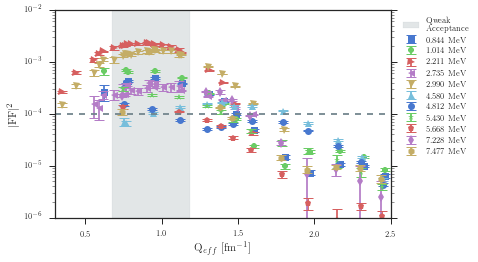

In [55]:
fig = pp.figure(figsize=figsize(1.0))
pp.errorbar(al_0_8440_MeV_state_Q_eff, al_0_8440_MeV_state_ff, yerr=al_0_8440_MeV_state_err, ls='None', marker='s', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[0]))
pp.errorbar(al_1_0140_MeV_state_Q_eff, al_1_0140_MeV_state_ff, yerr=al_1_0140_MeV_state_err, ls='None', marker='8', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[1]))
pp.errorbar(al_2_2110_MeV_state_Q_eff_mod, al_2_2110_MeV_state_ff_mod, yerr=al_2_2110_MeV_state_err_mod, ls='None', marker='>', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[2]))
pp.errorbar(al_2_7350_MeV_state_Q_eff_mod, al_2_7350_MeV_state_ff_mod, yerr=al_2_7350_MeV_state_err_mod, ls='None', marker='<', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[3]))
pp.errorbar(al_2_9900_MeV_state_Q_eff_mod, al_2_9900_MeV_state_ff_mod, yerr=al_2_9900_MeV_state_err_mod, ls='None', marker='v', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[4]))
pp.errorbar(al_4_5800_MeV_state_Q_eff, al_4_5800_MeV_state_ff, yerr=al_4_5800_MeV_state_err, ls='None', marker='^', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[10]))
pp.errorbar(al_4_8120_MeV_state_Q_eff, al_4_8120_MeV_state_ff, yerr=al_4_8120_MeV_state_err, ls='None', marker='o', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[11]))
pp.errorbar(al_5_4300_MeV_state_Q_eff, al_5_4300_MeV_state_ff, yerr=al_5_4300_MeV_state_err, ls='None', marker='*', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[14]))
pp.errorbar(al_5_6680_MeV_state_Q_eff, al_5_6680_MeV_state_ff, yerr=al_5_6680_MeV_state_err, ls='None', marker='p', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[17]))
pp.errorbar(al_7_2280_MeV_state_Q_eff, al_7_2280_MeV_state_ff, yerr=al_7_2280_MeV_state_err, ls='None', marker='d', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[27]))
pp.errorbar(al_7_4770_MeV_state_Q_eff, al_7_4770_MeV_state_ff, yerr=al_7_4770_MeV_state_err, ls='None', marker='h', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[30]))

#pp.errorbar(al_3_6800_MeV_state_Q_eff, al_3_6800_MeV_state_ff, yerr=al_3_6800_MeV_state_err, ls='None', marker='^', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[5]))
#pp.errorbar(al_3_9570_MeV_state_Q_eff, al_3_9570_MeV_state_ff, yerr=al_3_9570_MeV_state_err, ls='None', marker='o', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[6]))
#pp.errorbar(al_4_0550_MeV_state_Q_eff, al_4_0550_MeV_state_ff, yerr=al_4_0550_MeV_state_err, ls='None', marker='*', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[7]))
#pp.errorbar(al_4_4100_MeV_state_Q_eff, al_4_4100_MeV_state_ff, yerr=al_4_4100_MeV_state_err, ls='None', marker='p', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[8]))
#pp.errorbar(al_4_5100_MeV_state_Q_eff, al_4_5100_MeV_state_ff, yerr=al_4_5100_MeV_state_err, ls='None', marker='d', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[9]))
#pp.errorbar(al_5_1560_MeV_state_Q_eff, al_5_1560_MeV_state_ff, yerr=al_5_1560_MeV_state_err, ls='None', marker='H', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[12]))
#pp.errorbar(al_5_2480_MeV_state_Q_eff, al_5_2480_MeV_state_ff, yerr=al_5_2480_MeV_state_err, ls='None', marker='s', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[13]))
#pp.errorbar(al_5_5000_MeV_state_Q_eff, al_5_5000_MeV_state_ff, yerr=al_5_5000_MeV_state_err, ls='None', marker='>', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[15]))
#pp.errorbar(al_5_5510_MeV_state_Q_eff, al_5_5510_MeV_state_ff, yerr=al_5_5510_MeV_state_err, ls='None', marker='<', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[16]))
#pp.errorbar(al_5_8270_MeV_state_Q_eff, al_5_8270_MeV_state_ff, yerr=al_5_8270_MeV_state_err, ls='None', marker='^', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[18]))
#pp.errorbar(al_5_9600_MeV_state_Q_eff, al_5_9600_MeV_state_ff, yerr=al_5_9600_MeV_state_err, ls='None', marker='o', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[19]))
#pp.errorbar(al_6_1600_MeV_state_Q_eff, al_6_1600_MeV_state_ff, yerr=al_6_1600_MeV_state_err, ls='None', marker='*', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[20]))
#pp.errorbar(al_6_4770_MeV_state_Q_eff, al_6_4770_MeV_state_ff, yerr=al_6_4770_MeV_state_err, ls='None', marker='p', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[21]))
#pp.errorbar(al_6_5200_MeV_state_Q_eff, al_6_5200_MeV_state_ff, yerr=al_6_5200_MeV_state_err, ls='None', marker='d', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[22]))
#pp.errorbar(al_6_6050_MeV_state_Q_eff, al_6_6050_MeV_state_ff, yerr=al_6_6050_MeV_state_err, ls='None', marker='D', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[23]))
#pp.errorbar(al_6_6515_MeV_state_Q_eff, al_6_6515_MeV_state_ff, yerr=al_6_6515_MeV_state_err, ls='None', marker='h', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[24]))
#pp.errorbar(al_6_7100_MeV_state_Q_eff, al_6_7100_MeV_state_ff, yerr=al_6_7100_MeV_state_err, ls='None', marker='H', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[25]))
#pp.errorbar(al_6_9480_MeV_state_Q_eff, al_6_9480_MeV_state_ff, yerr=al_6_9480_MeV_state_err, ls='None', marker='s', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[26]))
#pp.errorbar(al_7_2900_MeV_state_Q_eff, al_7_2900_MeV_state_ff, yerr=al_7_2900_MeV_state_err, ls='None', marker='>', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[28]))
#pp.errorbar(al_7_4100_MeV_state_Q_eff, al_7_4100_MeV_state_ff, yerr=al_7_4100_MeV_state_err, ls='None', marker='<', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[29]))
#pp.errorbar(al_7_5800_MeV_state_Q_eff, al_7_5800_MeV_state_ff, yerr=al_7_5800_MeV_state_err, ls='None', marker='^', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[31]))
#pp.errorbar(al_7_6600_MeV_state_Q_eff, al_7_6600_MeV_state_ff, yerr=al_7_6600_MeV_state_err, ls='None', marker='o', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[32]))
#pp.errorbar(al_7_8000_MeV_state_Q_eff, al_7_8000_MeV_state_ff, yerr=al_7_8000_MeV_state_err, ls='None', marker='*', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[33]))
#pp.errorbar(al_8_4000_MeV_state_Q_eff, al_8_4000_MeV_state_ff, yerr=al_8_4000_MeV_state_err, ls='None', marker='p', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[34]))
#pp.errorbar(al_8_5200_MeV_state_Q_eff, al_8_5200_MeV_state_ff, yerr=al_8_5200_MeV_state_err, ls='None', marker='d', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[35]))
#pp.errorbar(al_8_8200_MeV_state_Q_eff, al_8_8200_MeV_state_ff, yerr=al_8_8200_MeV_state_err, ls='None', marker='D', capsize=5, capthick=1, label='{0} MeV'.format(energy_lvl[36]))

#vert_low, vert_high = pp.ylim()
pp.fill_between(qweak_acceptance, y_low, y_high, 
                color=sns.xkcd_rgb['steel grey'], alpha=0.2, label='Qweak \nAcceptance')
pp.plot((x_low,x_high),(1e-4,1e-4), ls='--', color=sns.xkcd_rgb['steel grey'])
pp.yscale('log')
pp.xlim(x_low,x_high)
pp.ylim(y_low, y_high)
pp.xlabel('Q$_{eff}$ [fm$^{-1}$]')
pp.ylabel('$|$FF$|^{2}$')
pp.tick_params(top=False)
pp.legend(bbox_to_anchor=(1.25,1.0), ncol=1)
#pp.legend(bbox_to_anchor=(1.30,1.0), ncol=2)
pp.savefig('plots/al_nuclear_excited_state_trunc_plot.pdf', bbox_inches='tight')
pp.savefig('plots/al_nuclear_excited_state_trunc_plot.png', bbox_inches='tight')
pp.savefig('plots/al_nuclear_excited_state_trunc_plot.pgf', bbox_inches='tight')
#pp.show()

Constant: 4.784e-04 +- 1.971e-05 
    Mean: 0.9599766 +- 0.0192711 
    Sigma: 0.3071582 +- 0.0123135 
    Chi**2: 29.938 
    DOF: 8 
    RChi**2: 3.742 
    ResidualAvg: -0.393 +- 1.625


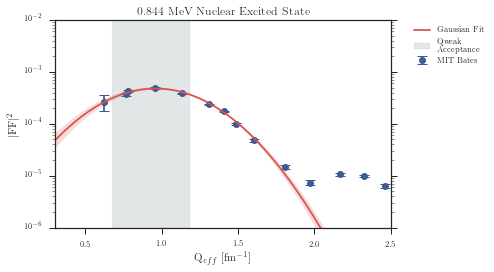

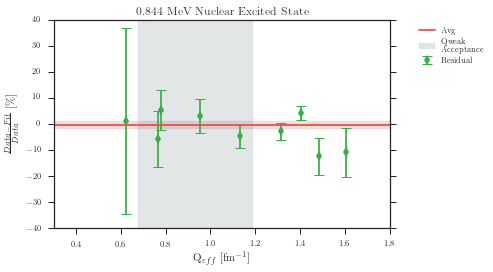

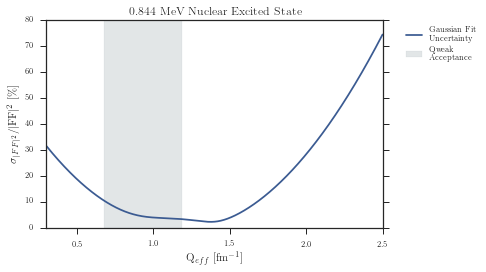

In [72]:
# 0.844 MeV Excited State Plots
plot_combo(al_0_8440_MeV_state_Q_eff, 
           al_0_8440_MeV_state_Q_eff_fit, 
           al_0_8440_MeV_state_ff,  
           al_0_8440_MeV_state_err,  
           al_0_8440_MeV_popt, 
           al_0_8440_MeV_pcov, 
           al_0_8440_MeV_chi2, 
           al_0_8440_MeV_pdiff, 
           al_0_8440_MeV_pdiff_err,
           al_0_8440_MeV_avg, 
           al_0_8440_MeV_avg_err, 
           energy_lvl[0])

Constant: 7.193e-04 +- 3.778e-05 
    Mean: 0.9049046 +- 0.0233719 
    Sigma: 0.2814528 +- 0.0133788 
    Chi**2: 66.610 
    DOF: 8 
    RChi**2: 8.326 
    ResidualAvg: 0.546 +- 2.104


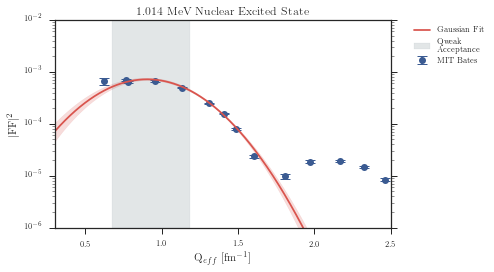

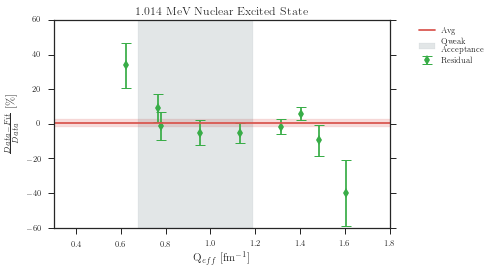

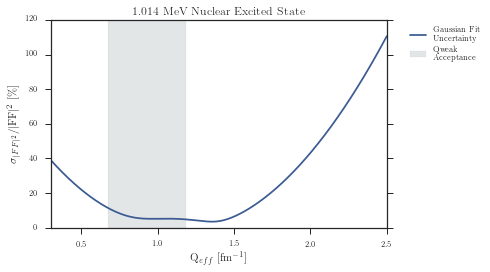

In [73]:
# 1.014 MeV Excited State Plots
plot_combo(al_1_0140_MeV_state_Q_eff, 
           al_1_0140_MeV_state_Q_eff_fit, 
           al_1_0140_MeV_state_ff,  
           al_1_0140_MeV_state_err,  
           al_1_0140_MeV_popt, 
           al_1_0140_MeV_pcov, 
           al_1_0140_MeV_chi2,
           al_1_0140_MeV_pdiff,
           al_1_0140_MeV_pdiff_err,
           al_1_0140_MeV_avg,
           al_1_0140_MeV_avg_err,
           energy_lvl[1])

Constant: 2.351e-03 +- 5.844e-05 
    Mean: 0.8895373 +- 0.0075427 
    Sigma: -0.2647485 +- 0.0044102 
    Chi**2: 318.885 
    DOF: 22 
    RChi**2: 14.495 
    ResidualAvg: 0.279 +- 0.973


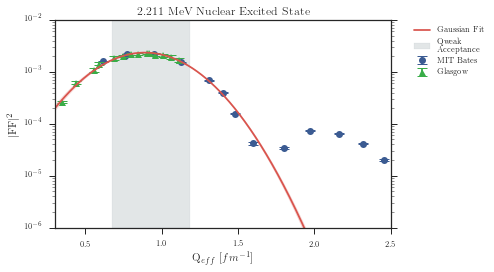

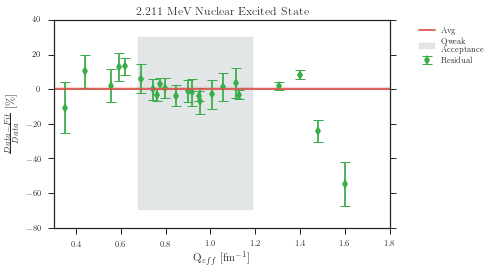

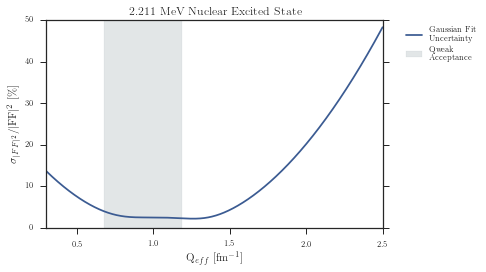

In [117]:
# 2.2110 MeV Excited State Plots
plot_combo_plus(al_2_2110_MeV_state_Q_eff, 
                al_2_2110_MeV_state_Q_eff_fit_mod, 
                al_2_2110_MeV_state_ff, 
                al_2_2110_MeV_state_err, 
                Singhal_2_210_MeV_state.Q_eff,
                Singhal_2_210_MeV_state.F_in_squared,
                Singhal_2_210_MeV_state.F_in_squared_err,
                al_2_2110_MeV_popt, 
                al_2_2110_MeV_pcov, 
                al_2_2110_MeV_chi2,
                al_2_2110_MeV_pdiff,
                al_2_2110_MeV_pdiff_err,
                al_2_2110_MeV_avg,
                al_2_2110_MeV_avg_err,
                energy_lvl[2])

Constant: 3.183e-04 +- 8.182e-06 
    Mean: 0.9614569 +- 0.0237207 
    Sigma: 0.4138585 +- 0.0194921 
    Chi**2: 53.736 
    DOF: 20 
    RChi**2: 2.687 
    ResidualAvg: 0.722 +- 1.203


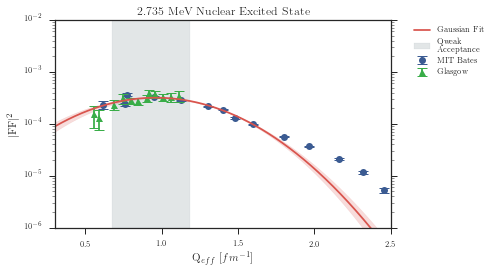

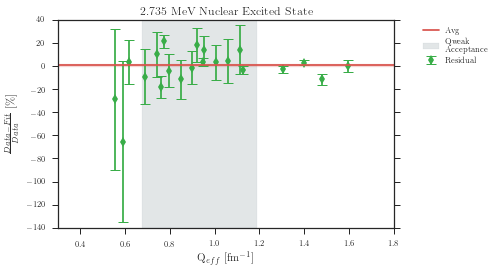

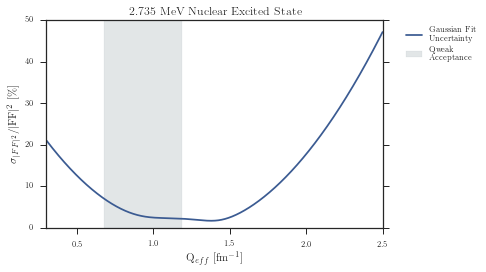

In [75]:
# 2.7350 MeV Excited State Plots
plot_combo_plus(al_2_7350_MeV_state_Q_eff, 
                al_2_7350_MeV_state_Q_eff_fit_mod, 
                al_2_7350_MeV_state_ff,  
                al_2_7350_MeV_state_err,
                Singhal_2_734_MeV_state.Q_eff,
                Singhal_2_734_MeV_state.F_in_squared,
                Singhal_2_734_MeV_state.F_in_squared_err,
                al_2_7350_MeV_popt, 
                al_2_7350_MeV_pcov, 
                al_2_7350_MeV_chi2,
                al_2_7350_MeV_pdiff,
                al_2_7350_MeV_pdiff_err,
                al_2_7350_MeV_avg,
                al_2_7350_MeV_avg_err,
                energy_lvl[3])

Constant: 1.665e-03 +- 3.304e-05 
    Mean: 0.9577090 +- 0.0060561 
    Sigma: -0.2999183 +- 0.0047127 
    Chi**2: 146.824 
    DOF: 23 
    RChi**2: 6.384 
    ResidualAvg: 0.244 +- 0.844


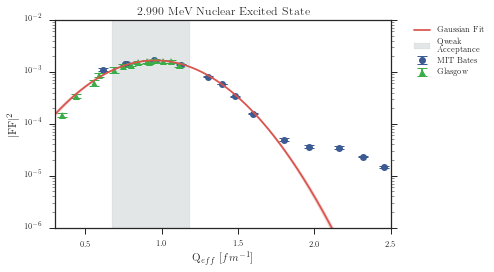

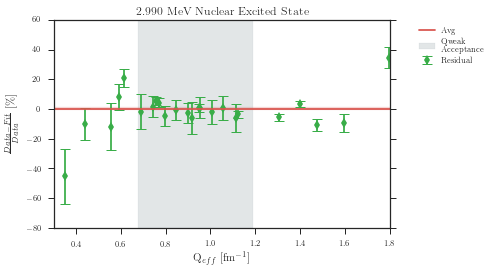

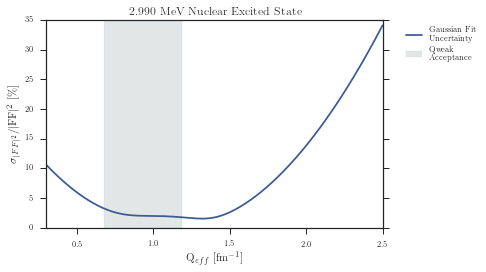

In [79]:
# 2.9900 MeV Excited State Plots
plot_combo_plus(al_2_9900_MeV_state_Q_eff, 
                al_2_9900_MeV_state_Q_eff_fit_mod, 
                al_2_9900_MeV_state_ff, 
                al_2_9900_MeV_state_err,  
                Singhal_3_000_MeV_state.Q_eff,
                Singhal_3_000_MeV_state.F_in_squared,
                Singhal_3_000_MeV_state.F_in_squared_err,
                al_2_9900_MeV_popt, 
                al_2_9900_MeV_pcov, 
                al_2_9900_MeV_chi2,
                al_2_9900_MeV_pdiff,
                al_2_9900_MeV_pdiff_err,
                al_2_9900_MeV_avg,
                al_2_9900_MeV_avg_err,
                energy_lvl[4])

Constant: 1.593e-04 +- 3.117e-06 
    Mean: 1.3895749 +- 0.0156153 
    Sigma: 0.4825382 +- 0.0240437 
    Chi**2: 14.055 
    DOF: 8 
    RChi**2: 1.757 
    ResidualAvg: -0.096 +- 1.390


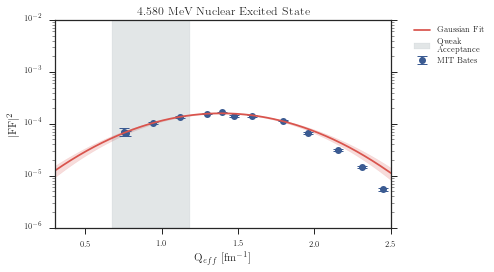

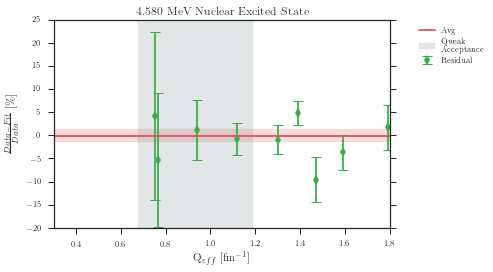

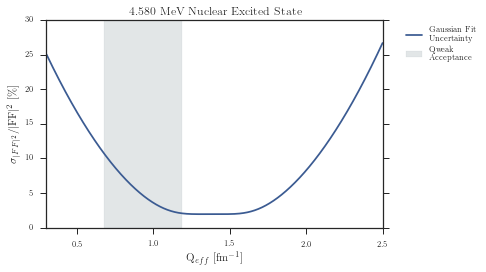

In [80]:
# 4.5800 MeV Excited State Plots
plot_combo(al_4_5800_MeV_state_Q_eff, 
           al_4_5800_MeV_state_Q_eff_fit, 
           al_4_5800_MeV_state_ff, 
           al_4_5800_MeV_state_err,  
           al_4_5800_MeV_popt, 
           al_4_5800_MeV_pcov, 
           al_4_5800_MeV_chi2,
           al_4_5800_MeV_pdiff,
           al_4_5800_MeV_pdiff_err,
           al_4_5800_MeV_avg,
           al_4_5800_MeV_avg_err,
           energy_lvl[10])

Constant: 2.300e-04 +- 2.283e-04 
    Mean: 0.2535563 +- 0.8879895 
    Sigma: 0.5944416 +- 0.3259818 
    Chi**2: 4.377 
    DOF: 3 
    RChi**2: 1.459 
    ResidualAvg: 0.755 +- 4.401


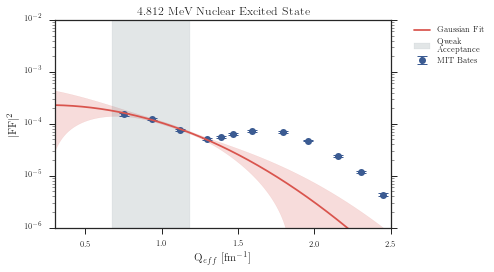

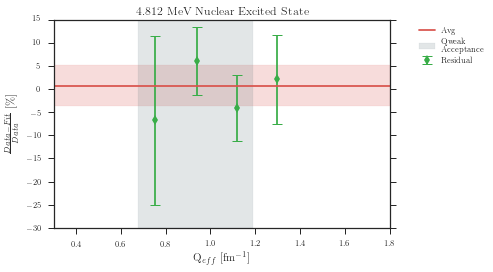

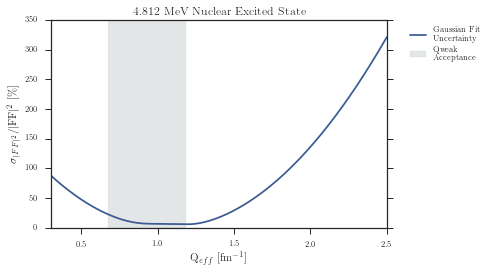

In [81]:
# 4.8120 MeV Excited State Plots
plot_combo(al_4_8120_MeV_state_Q_eff, 
           al_4_8120_MeV_state_Q_eff_fit, 
           al_4_8120_MeV_state_ff, 
           al_4_8120_MeV_state_err, 
           al_4_8120_MeV_popt, 
           al_4_8120_MeV_pcov, 
           al_4_8120_MeV_chi2,
           al_4_8120_MeV_pdiff,
           al_4_8120_MeV_pdiff_err,
           al_4_8120_MeV_avg,
           al_4_8120_MeV_avg_err,
           energy_lvl[11])

Constant: 2.687e-04 +- 2.899e-05 
    Mean: 0.7792557 +- 0.1042354 
    Sigma: 0.4465656 +- 0.0504332 
    Chi**2: 14.418 
    DOF: 7 
    RChi**2: 2.060 
    ResidualAvg: 1.156 +- 3.065


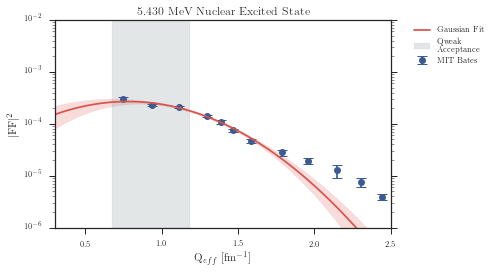

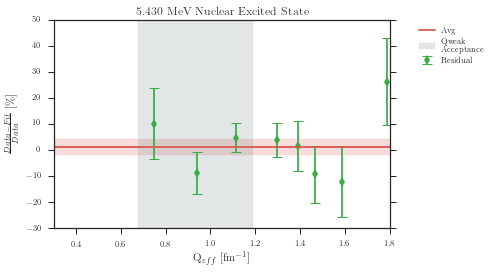

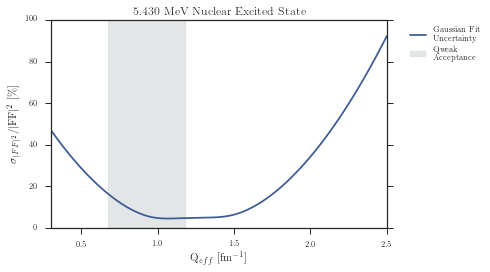

In [82]:
# 5.4300 MeV Excited State Plots
plot_combo(al_5_4300_MeV_state_Q_eff, 
           al_5_4300_MeV_state_Q_eff_fit, 
           al_5_4300_MeV_state_ff, 
           al_5_4300_MeV_state_err, 
           al_5_4300_MeV_popt, 
           al_5_4300_MeV_pcov, 
           al_5_4300_MeV_chi2,
           al_5_4300_MeV_pdiff,
           al_5_4300_MeV_pdiff_err,
           al_5_4300_MeV_avg,
           al_5_4300_MeV_avg_err,
           energy_lvl[14])

Constant: 1.375e-04 +- 1.025e-05 
    Mean: 0.8912329 +- 0.0485835 
    Sigma: -0.3635918 +- 0.0232647 
    Chi**2: 10.118 
    DOF: 6 
    RChi**2: 1.686 
    ResidualAvg: 0.783 +- 2.550


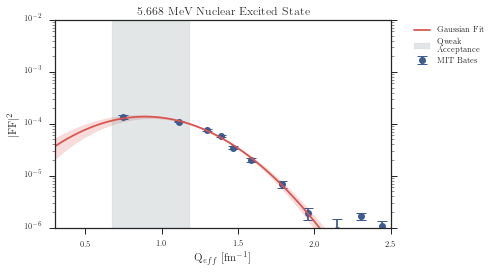

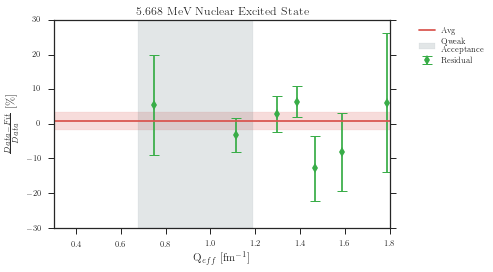

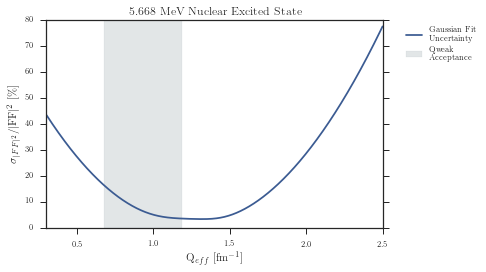

In [83]:
# 5.6680 MeV Excited State Plots
plot_combo(al_5_6680_MeV_state_Q_eff, 
           al_5_6680_MeV_state_Q_eff_fit, 
           al_5_6680_MeV_state_ff, 
           al_5_6680_MeV_state_err, 
           al_5_6680_MeV_popt, 
           al_5_6680_MeV_pcov, 
           al_5_6680_MeV_chi2,
           al_5_6680_MeV_pdiff,
           al_5_6680_MeV_pdiff_err,
           al_5_6680_MeV_avg,
           al_5_6680_MeV_avg_err,
           energy_lvl[17])

Constant: 3.562e-04 +- 2.593e-05 
    Mean: 1.0591602 +- 0.0273296 
    Sigma: -0.3218205 +- 0.0159808 
    Chi**2: 19.346 
    DOF: 5 
    RChi**2: 3.869 
    ResidualAvg: 4.968 +- 3.087


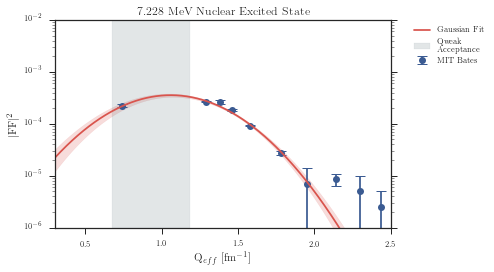

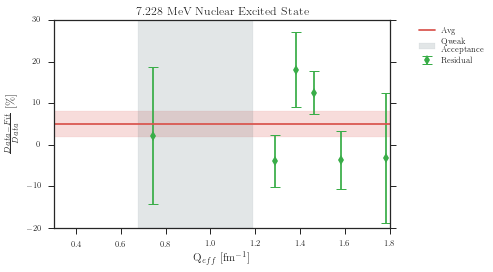

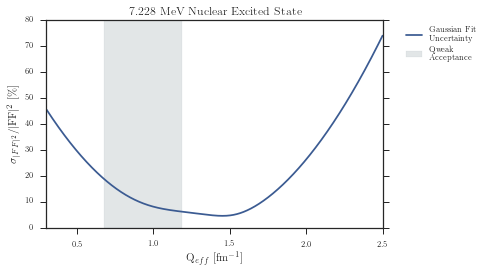

In [84]:
# 7.2280 MeV Excited State Plots
plot_combo(al_7_2280_MeV_state_Q_eff, 
           al_7_2280_MeV_state_Q_eff_fit, 
           al_7_2280_MeV_state_ff, 
           al_7_2280_MeV_state_err, 
           al_7_2280_MeV_popt, 
           al_7_2280_MeV_pcov, 
           al_7_2280_MeV_chi2,
           al_7_2280_MeV_pdiff,
           al_7_2280_MeV_pdiff_err,
           al_7_2280_MeV_avg,
           al_7_2280_MeV_avg_err,
           energy_lvl[27])

Constant: 2.102e-04 +- 3.305e-05 
    Mean: 1.0784616 +- 0.0419452 
    Sigma: -0.2994193 +- 0.0269216 
    Chi**2: 7.327 
    DOF: 3 
    RChi**2: 2.442 
    ResidualAvg: -0.783 +- 6.509


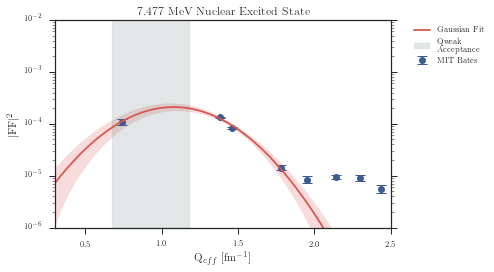

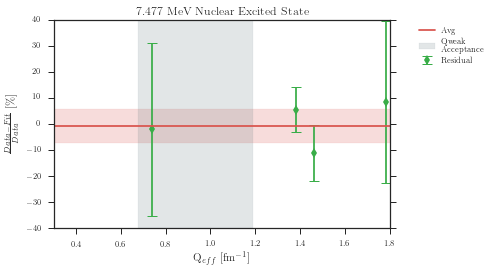

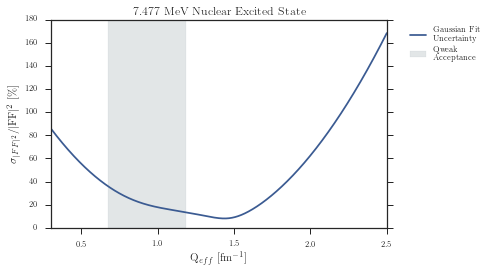

In [85]:
# 7.4770 MeV Excited State Plots
plot_combo(al_7_4770_MeV_state_Q_eff, 
           al_7_4770_MeV_state_Q_eff_fit, 
           al_7_4770_MeV_state_ff, 
           al_7_4770_MeV_state_err,
           al_7_4770_MeV_popt, 
           al_7_4770_MeV_pcov, 
           al_7_4770_MeV_chi2,
           al_7_4770_MeV_pdiff,
           al_7_4770_MeV_pdiff_err,
           al_7_4770_MeV_avg,
           al_7_4770_MeV_avg_err,
           energy_lvl[30])

In [86]:
rupesh_fit_values = pd.read_csv('data/rupesh_inelasticSPS_fit_values.dat')

In [87]:
rupesh_fit_values[:]

,energy,fconstant,fmean,fsigma
0,0.844,0.000427,0.958792,0.341168
1,1.016,0.000706,0.868077,0.350506
2,2.211,0.002337,0.857955,0.290595
3,2.735,0.000306,0.955732,0.379688
4,2.990,0.001598,0.948107,0.330035
5,3.680,0.000042,0.992771,0.395955
6,4.510,0.000135,1.340052,0.302506
7,4.580,0.000162,1.297271,0.352787


In [88]:
mit_bates_fit_energy = np.array((energy_lvl[0], 
                        energy_lvl[1], 
                        energy_lvl[2], 
                        energy_lvl[3], 
                        energy_lvl[4], 
                        energy_lvl[10], 
                        energy_lvl[11], 
                        energy_lvl[14], 
                        energy_lvl[17], 
                        energy_lvl[27], 
                        energy_lvl[30]))
mit_bates_fit_constant = np.array((al_0_8440_MeV_popt[0], 
                          al_1_0140_MeV_popt[0], 
                          al_2_2110_MeV_popt[0], 
                          al_2_7350_MeV_popt[0], 
                          al_2_9900_MeV_popt[0], 
                          al_4_5800_MeV_popt[0], 
                          al_4_8120_MeV_popt[0], 
                          al_5_4300_MeV_popt[0], 
                          al_5_6680_MeV_popt[0], 
                          al_7_2280_MeV_popt[0], 
                          al_7_4770_MeV_popt[0]))
mit_bates_fit_constant_err = np.sqrt((al_0_8440_MeV_pcov[0,0], 
                              al_1_0140_MeV_pcov[0,0], 
                              al_2_2110_MeV_pcov[0,0], 
                              al_2_7350_MeV_pcov[0,0], 
                              al_2_9900_MeV_pcov[0,0], 
                              al_4_5800_MeV_pcov[0,0], 
                              al_4_8120_MeV_pcov[0,0], 
                              al_5_4300_MeV_pcov[0,0], 
                              al_5_6680_MeV_pcov[0,0], 
                              al_7_2280_MeV_pcov[0,0], 
                              al_7_4770_MeV_pcov[0,0]))
mit_bates_fit_mean = np.array((al_0_8440_MeV_popt[1], 
                      al_1_0140_MeV_popt[1], 
                      al_2_2110_MeV_popt[1], 
                      al_2_7350_MeV_popt[1], 
                      al_2_9900_MeV_popt[1], 
                      al_4_5800_MeV_popt[1], 
                      al_4_8120_MeV_popt[1], 
                      al_5_4300_MeV_popt[1], 
                      al_5_6680_MeV_popt[1], 
                      al_7_2280_MeV_popt[1], 
                      al_7_4770_MeV_popt[1]))
mit_bates_fit_mean_err = np.sqrt((al_0_8440_MeV_pcov[1,1], 
                          al_1_0140_MeV_pcov[1,1], 
                          al_2_2110_MeV_pcov[1,1], 
                          al_2_7350_MeV_pcov[1,1], 
                          al_2_9900_MeV_pcov[1,1], 
                          al_4_5800_MeV_pcov[1,1], 
                          al_4_8120_MeV_pcov[1,1], 
                          al_5_4300_MeV_pcov[1,1], 
                          al_5_6680_MeV_pcov[1,1],
                          al_7_2280_MeV_pcov[1,1], 
                          al_7_4770_MeV_pcov[1,1]))
mit_bates_fit_sigma = np.array((al_0_8440_MeV_popt[2], 
                                al_1_0140_MeV_popt[2], 
                       al_2_2110_MeV_popt[2], 
                       al_2_7350_MeV_popt[2], 
                       al_2_9900_MeV_popt[2], 
                       al_4_5800_MeV_popt[2], 
                       al_4_8120_MeV_popt[2], 
                       al_5_4300_MeV_popt[2], 
                       al_5_6680_MeV_popt[2], 
                       al_7_2280_MeV_popt[2], 
                       al_7_4770_MeV_popt[2]))
mit_bates_fit_sigma_err = np.sqrt((al_0_8440_MeV_pcov[2,2], 
                           al_1_0140_MeV_pcov[2,2], 
                           al_2_2110_MeV_pcov[2,2], 
                           al_2_7350_MeV_pcov[2,2], 
                           al_2_9900_MeV_pcov[2,2], 
                           al_4_5800_MeV_pcov[2,2], 
                           al_4_8120_MeV_pcov[2,2], 
                           al_5_4300_MeV_pcov[2,2], 
                           al_5_6680_MeV_pcov[2,2], 
                           al_7_2280_MeV_pcov[2,2], 
                           al_7_4770_MeV_pcov[2,2]))
mit_bates_fit_chi2 = np.array((al_0_8440_MeV_chi2, 
                               al_1_0140_MeV_chi2, 
                               al_2_2110_MeV_chi2, 
                               al_2_7350_MeV_chi2, 
                               al_2_9900_MeV_chi2, 
                               al_4_5800_MeV_chi2, 
                               al_4_8120_MeV_chi2, 
                               al_5_4300_MeV_chi2, 
                               al_5_6680_MeV_chi2, 
                               al_7_2280_MeV_chi2, 
                               al_7_4770_MeV_chi2))
mit_bates_fit_dof = np.array(((len(al_0_8440_MeV_state_Q_eff_fit)-1),
                              (len(al_1_0140_MeV_state_Q_eff_fit)-1),
                              (len(al_2_2110_MeV_state_Q_eff_fit_mod)-1),
                              (len(al_2_7350_MeV_state_Q_eff_fit_mod)-1),
                              (len(al_2_9900_MeV_state_Q_eff_fit_mod)-1),
                              (len(al_4_5800_MeV_state_Q_eff_fit)-1),
                              (len(al_4_8120_MeV_state_Q_eff_fit)-1),
                              (len(al_5_4300_MeV_state_Q_eff_fit)-1),
                              (len(al_5_6680_MeV_state_Q_eff_fit)-1),
                              (len(al_7_2280_MeV_state_Q_eff_fit)-1),
                              (len(al_7_4770_MeV_state_Q_eff_fit)-1)))
mit_bates_residual_avg = np.array((al_0_8440_MeV_avg, 
                                   al_1_0140_MeV_avg, 
                                   al_2_2110_MeV_avg, 
                                   al_2_7350_MeV_avg, 
                                   al_2_9900_MeV_avg, 
                                   al_4_5800_MeV_avg, 
                                   al_4_8120_MeV_avg, 
                                   al_5_4300_MeV_avg, 
                                   al_5_6680_MeV_avg, 
                                   al_7_2280_MeV_avg, 
                                   al_7_4770_MeV_avg))
mit_bates_residual_avg_err = np.array((al_0_8440_MeV_avg_err, 
                                       al_1_0140_MeV_avg_err, 
                                       al_2_2110_MeV_avg_err, 
                                       al_2_7350_MeV_avg_err, 
                                       al_2_9900_MeV_avg_err, 
                                       al_4_5800_MeV_avg_err, 
                                       al_4_8120_MeV_avg_err, 
                                       al_5_4300_MeV_avg_err, 
                                       al_5_6680_MeV_avg_err, 
                                       al_7_2280_MeV_avg_err, 
                                       al_7_4770_MeV_avg_err))
fit_parameters = {'energy': mit_bates_fit_energy,
                  'const' : mit_bates_fit_constant, 
                  'const_err': mit_bates_fit_constant_err,
                  'mean_value' : mit_bates_fit_mean, 
                  'mean_err' : mit_bates_fit_mean_err, 
                  'sigma' : mit_bates_fit_sigma, 
                  'sigma_err': mit_bates_fit_sigma_err, 
                  'chi2' : mit_bates_fit_chi2,
                  'dof' : mit_bates_fit_dof,
                  'rchi2' : mit_bates_fit_chi2/mit_bates_fit_dof, 
                  'residual_avg' : mit_bates_residual_avg, 
                  'residual_avg_err' : mit_bates_residual_avg_err}
fit_parameters_frame = pd.DataFrame(fit_parameters, columns=['energy',
                                                             'const',
                                                             'const_err',
                                                             'mean_value',
                                                             'mean_err',
                                                             'sigma',
                                                             'sigma_err',
                                                             'chi2',
                                                             'dof',
                                                             'rchi2',
                                                             'residual_avg',
                                                             'residual_avg_err'])
fit_parameters_frame.to_csv('data/al_nuclear_excited_state_fit_parameters.dat', index=False)

In [89]:
fit_parameters_frame[:]

,energy,const,const_err,mean_value,mean_err,sigma,sigma_err,chi2,dof,rchi2,residual_avg,residual_avg_err
0,0.844,0.000478,0.000020,0.959977,0.019271,0.307158,0.012313,29.937708,8,3.742213,-0.392546,1.625300
1,1.014,0.000719,0.000038,0.904905,0.023372,0.281453,0.013379,66.609572,8,8.326197,0.545682,2.104469
2,2.211,0.002351,0.000058,0.889537,0.007543,-0.264748,0.004410,318.885136,22,14.494779,0.278983,0.972556
3,2.735,0.000318,0.000008,0.961457,0.023721,0.413858,0.019492,53.735564,20,2.686778,0.722041,1.203404
4,2.990,0.001665,0.000033,0.957709,0.006056,-0.299918,0.004713,146.823675,23,6.383638,0.243535,0.843914
5,4.580,0.000159,0.000003,1.389575,0.015615,0.482538,0.024044,14.054945,8,1.756868,-0.096306,1.389858
6,4.812,0.000230,0.000228,0.253556,0.887989,0.594442,0.325982,4.376974,3,1.458991,0.754527,4.401007
7,5.430,0.000269,0.000029,0.779256,0.104235,0.446566,0.050433,14.417638,7,2.059663,1.156398,3.065441
8,5.668,0.000137,0.000010,0.891233,0.048583,-0.363592,0.023265,10.117905,6,1.686318,0.783328,2.550444
9,7.228,0.000356,0.000026,1.059160,0.027330,-0.321820,0.015981,19.346473,5,3.869295,4.968245,3.087274


In [90]:
100*(fit_parameters_frame.const_err/fit_parameters_frame.const)

0      4.121048
1      5.252199
2      2.485455
3      2.570162
4      1.984581
5      1.956199
6     99.259466
7     10.788679
8      7.454486
9      7.280512
10    15.721846
dtype: float64

In [91]:
100.0*(fit_parameters_frame.mean_err/fit_parameters_frame.mean_value)

0       2.007459
1       2.582802
2       0.847935
3       2.467165
4       0.632351
5       1.123749
6     350.213990
7      13.376275
8       5.451263
9       2.580312
10      3.889351
dtype: float64

In [92]:
100.0*abs(fit_parameters_frame.sigma_err/fit_parameters_frame.sigma)

0      4.008837
1      4.753486
2      1.665816
3      4.709837
4      1.571342
5      4.982755
6     54.838316
7     11.293569
8      6.398577
9      4.965755
10     8.991267
dtype: float64

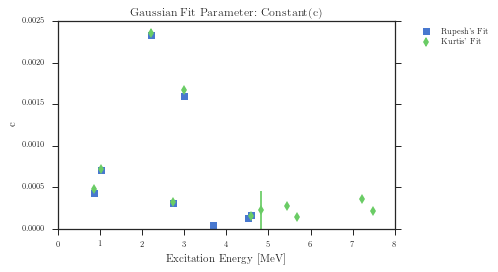

In [100]:
pp.figure(figsize=figsize(1.0))
pp.plot(rupesh_fit_values.energy, rupesh_fit_values.fconstant, ls='None', marker='s', label="Rupesh's Fit")
pp.errorbar(mit_bates_fit_energy, mit_bates_fit_constant, yerr=mit_bates_fit_constant_err, ls='None', marker='d', label="Kurtis' Fit")
pp.title('Gaussian Fit Parameter: Constant(c)')
pp.xlabel('Excitation Energy [MeV]')
pp.ylabel('c')
pp.legend(bbox_to_anchor=(1.30, 1.0))
pp.tick_params(top=False)
pp.savefig('plots/excited_state_fit_parameter_constant.pdf', bbox_inches='tight')
pp.savefig('plots/excited_state_fit_parameter_constant.png', bbox_inches='tight')
pp.savefig('plots/excited_state_fit_parameter_constant.pgf', bbox_inches='tight')
pp.show()

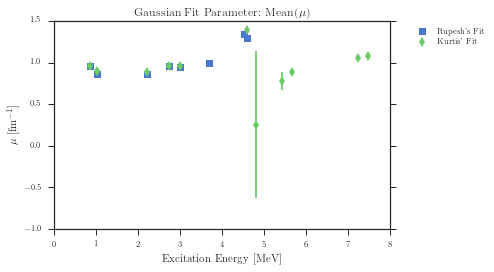

In [99]:
pp.figure(figsize=figsize(1.0))
pp.plot(rupesh_fit_values.energy, rupesh_fit_values.fmean, ls='None', marker='s', label="Rupesh's Fit")
pp.errorbar(mit_bates_fit_energy, mit_bates_fit_mean, yerr=mit_bates_fit_mean_err, ls='None', marker='d', label="Kurtis' Fit")
pp.title('Gaussian Fit Parameter: Mean($\mu$)')
pp.xlabel('Excitation Energy [MeV]')
pp.ylabel('$\mu$ [fm$^{-1}$]')
pp.legend(bbox_to_anchor=(1.30, 1.0))
pp.tick_params(top=False)
pp.savefig('plots/excited_state_fit_parameter_mean.pdf', bbox_inches='tight')
pp.savefig('plots/excited_state_fit_parameter_mean.png', bbox_inches='tight')
pp.savefig('plots/excited_state_fit_parameter_mean.pgf', bbox_inches='tight')
pp.show()

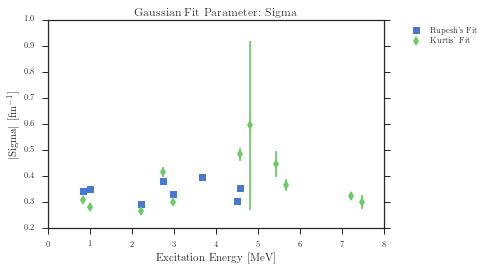

In [98]:
pp.figure(figsize=figsize(1.0))
pp.plot(rupesh_fit_values.energy, rupesh_fit_values.fsigma, ls='None', marker='s', label="Rupesh's Fit")
pp.errorbar(mit_bates_fit_energy, np.absolute(mit_bates_fit_sigma), yerr=mit_bates_fit_sigma_err, ls='None', marker='d', label="Kurtis' Fit")
pp.title('Gaussian Fit Parameter: Sigma')
pp.xlabel('Excitation Energy [MeV]')
pp.ylabel('$|$Sigma$|$ [fm$^{-1}$]')
pp.legend(bbox_to_anchor=(1.30, 1.0))
pp.tick_params(top=False)
pp.savefig('plots/excited_state_fit_parameter_sigma.pdf', bbox_inches='tight')
pp.savefig('plots/excited_state_fit_parameter_sigma.png', bbox_inches='tight')
pp.savefig('plots/excited_state_fit_parameter_sigma.pgf', bbox_inches='tight')
pp.show()

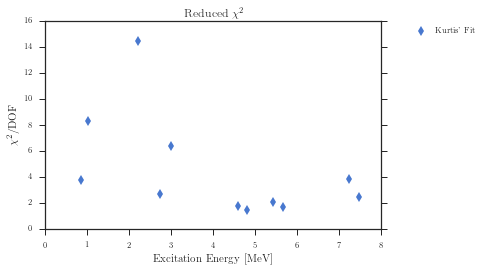

In [101]:
pp.figure(figsize=figsize(1.0))
pp.plot(mit_bates_fit_energy, mit_bates_fit_chi2/mit_bates_fit_dof, ls='None', marker='d', label="Kurtis' Fit")
pp.title('Reduced $\chi^{2}$')
pp.xlabel('Excitation Energy [MeV]')
pp.ylabel('$\chi^{2}$/DOF')
pp.legend(bbox_to_anchor=(1.30, 1.0))
pp.tick_params(top=False)
pp.savefig('plots/excited_state_fit_parameter_chi2.pdf', bbox_inches='tight')
pp.savefig('plots/excited_state_fit_parameter_chi2.png', bbox_inches='tight')
pp.savefig('plots/excited_state_fit_parameter_chi2.pgf', bbox_inches='tight')
pp.show()

In [102]:
mit_bates_fit_pcov = np.ndarray(shape=(11,3,3))
for i in range(3):
    for j in range(3):
        mit_bates_fit_pcov[0,i,j] = al_0_8440_MeV_pcov[i,j]
        mit_bates_fit_pcov[1,i,j] = al_1_0140_MeV_pcov[i,j]
        mit_bates_fit_pcov[2,i,j] = al_2_2110_MeV_pcov[i,j]
        mit_bates_fit_pcov[3,i,j] = al_2_7350_MeV_pcov[i,j]
        mit_bates_fit_pcov[4,i,j] = al_2_9900_MeV_pcov[i,j]
        mit_bates_fit_pcov[5,i,j] = al_4_5800_MeV_pcov[i,j]
        mit_bates_fit_pcov[6,i,j] = al_4_8120_MeV_pcov[i,j]
        mit_bates_fit_pcov[7,i,j] = al_5_4300_MeV_pcov[i,j]
        mit_bates_fit_pcov[8,i,j] = al_5_6680_MeV_pcov[i,j]
        mit_bates_fit_pcov[9,i,j] = al_7_2280_MeV_pcov[i,j]
        mit_bates_fit_pcov[10,i,j] = al_7_4770_MeV_pcov[i,j]

In [103]:
residual_excited_states_percent_err = np.zeros(len(mit_bates_residual_avg))
for i in range(len(mit_bates_residual_avg)):
    if mit_bates_residual_avg[i] < 0.0:
        residual_excited_states_percent_err[i] = (abs(mit_bates_residual_avg[i] - mit_bates_residual_avg_err[i]))
    elif mit_bates_residual_avg [i] > 0.0:
        residual_excited_states_percent_err[i] = (abs(mit_bates_residual_avg[i] + mit_bates_residual_avg_err[i]))
    else:
        print('Error')

In [104]:
residual_excited_states_percent_err[:]

array([ 2.01784557,  2.65015136,  1.25153844,  1.92544441,  1.08744885,
        1.48616406,  5.1555344 ,  4.22183896,  3.33377238,  8.0555184 ,
        7.29131797])

In [105]:
q_range = np.linspace(x_low,x_high,1000)
total_excited_states = np.zeros(len(q_range))
total_excited_states_err = np.zeros(len(q_range))
for q in range(len(q_range)):
    momemtum_transfer_point = q_range[q]*np.ones(len(mit_bates_fit_constant))
    excited_states_ff = np.zeros(len(mit_bates_fit_constant))
    excited_states_err = np.zeros(len(mit_bates_fit_constant))
    for i in range(len(mit_bates_fit_constant)):
        excited_states_ff[i] = gaussian(momemtum_transfer_point[i], 
                                    mit_bates_fit_constant[i], 
                                    mit_bates_fit_mean[i], 
                                    mit_bates_fit_sigma[i])
        excited_states_err[i] = gaussian_err(momemtum_transfer_point[i], 
                                         mit_bates_fit_pcov[i,:],
                                         mit_bates_fit_constant[i], 
                                         mit_bates_fit_mean[i], 
                                         mit_bates_fit_sigma[i])
    #residual_excited_states_err = excited_states_ff*(residual_excited_states_percent_err/100.0)
    total_excited_states[q] = np.sum(excited_states_ff)
    total_excited_states_err[q] = np.sqrt(np.sum(np.square(excited_states_err)))
    del momemtum_transfer_point
    del excited_states_ff
    del excited_states_err
    #total_residual_excited_states_err = np.sqrt(np.sum(np.square(residual_excited_states_err)))

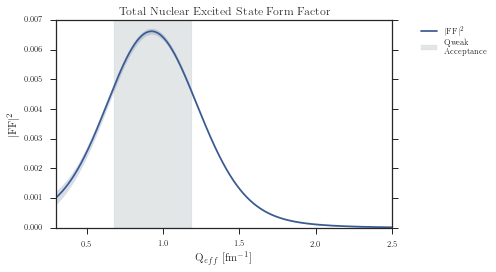

In [110]:
pp.figure(figsize=figsize(1.0))
pp.plot(q_range,total_excited_states, color=sns.xkcd_rgb['denim blue'], label='$|$FF$|^{2}$')
pp.fill_between(q_range,
                total_excited_states-total_excited_states_err,
                total_excited_states+total_excited_states_err, 
                color=sns.xkcd_rgb['denim blue'], 
                alpha=0.2)
vert_low, vert_high = pp.ylim()
pp.fill_between(qweak_acceptance, vert_low, vert_high, 
                    color=sns.xkcd_rgb['steel grey'], alpha=0.2, label='Qweak \nAcceptance')
pp.xlim((x_low,x_high))
pp.legend(bbox_to_anchor=(1.30, 1.0))
pp.tick_params(top=False)
pp.title('Total Nuclear Excited State Form Factor')
pp.xlabel('Q$_{eff}$ [fm$^{-1}$]')
pp.ylabel('$|$FF$|^{2}$')
pp.savefig('plots/total_excited_state_ff.pdf', bbox_inches='tight')
pp.savefig('plots/total_excited_state_ff.png', bbox_inches='tight')
pp.savefig('plots/total_excited_state_ff.pgf', bbox_inches='tight')
pp.show()

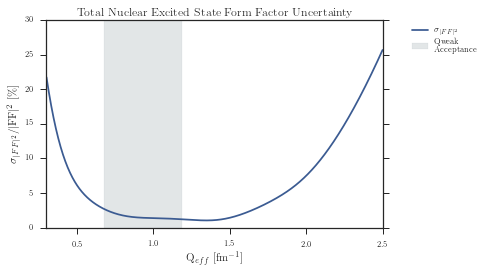

In [114]:
pp.figure(figsize=figsize(1.0))
pp.plot(q_range,
        100.0*(total_excited_states_err/total_excited_states), 
        color=sns.xkcd_rgb['denim blue'], label='$\\sigma_{|FF|^{2}}$')
pp.xlim((x_low,x_high))
vert_low, vert_high = pp.ylim()
pp.fill_between(qweak_acceptance, vert_low, vert_high, 
                    color=sns.xkcd_rgb['steel grey'], alpha=0.2, label='Qweak \nAcceptance')
pp.legend(bbox_to_anchor=(1.30, 1.0))
pp.tick_params(top=False)
pp.title('Total Nuclear Excited State Form Factor Uncertainty')
pp.xlabel('Q$_{eff}$ [fm$^{-1}$]')
pp.ylabel('$\\sigma_{|FF|^{2}}$/$|$FF$|^{2}$ [\%]')
pp.savefig('plots/total_excited_state_ff_uncertainty.pdf', bbox_inches='tight')
pp.savefig('plots/total_excited_state_ff_uncertainty.png', bbox_inches='tight')
pp.savefig('plots/total_excited_state_ff_uncertainty.pgf', bbox_inches='tight')
pp.show()

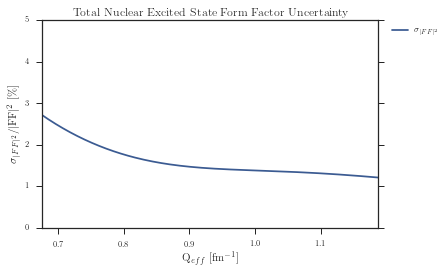

In [113]:
pp.figure(figsize=figsize(1.0))
pp.plot(q_range,
        100.0*(total_excited_states_err/total_excited_states), 
        color=sns.xkcd_rgb['denim blue'], label='$\\sigma_{|FF|^{2}}$')
pp.xlim(qweak_acceptance)
pp.ylim((0.0,5.0))
#vert_low, vert_high = pp.ylim()
#pp.fill_between(qweak_acceptance, vert_low, vert_high, 
#                    color=sns.xkcd_rgb['steel grey'], alpha=0.2, label='Qweak \nAcceptance')
pp.legend(bbox_to_anchor=(1.20, 1.0))
pp.tick_params(top=False)
pp.title('Total Nuclear Excited State Form Factor Uncertainty')
pp.xlabel('Q$_{eff}$ [fm$^{-1}$]')
pp.ylabel('$\\sigma_{|FF|^{2}}$/$|$FF$|^{2}$ [\%]')
pp.savefig('plots/total_excited_state_ff_uncertainty_zoom.pdf', bbox_inches='tight')
pp.savefig('plots/total_excited_state_ff_uncertainty_zoom.png', bbox_inches='tight')
pp.savefig('plots/total_excited_state_ff_uncertainty_zoom.pgf', bbox_inches='tight')
pp.show()